# Exploring representation bias of countries in Wikipedia using the Wikispeedia Dataset

## Project Milestone 3

### Research Question: 
* Is there a representation bias in Wikipedia about countries?
* What does the behaviour of the players tell us about their cultural knowledge about countries?

### Notebook structure

- Loading data
- Data wrangling
- Data analysis
    - Part 1: Descriptive statistics and naive statistical analysis of the Wikispeedia Dataset
        * A: Exploratory data analysis
        * B: Length of the articles* and their number of hyperlinks
        * C: Sentiment analysis of articles*
    - Part 2: Descriptive statistics and naive statistical analysis about the behaviour of the players
        * A: How different is the ratio of finished pathways, where articles* are the start/target?
        * B: How different is the length of the pathway taken respectively the time needed, where articles* are the start/target?
        * C: How often does an article* appear in a pathway where it is neither the start nor the traget?
    - Part 3: Analysis of biases
        * A: Establish baseline (e.g. expected length for world mean population or economic strength)
        * B: By investigating article length, article sentiment or number of hyperlinks while controlling for e.g. population size, economic power or if English is an official language, is there a representation bias based on countries in Wikipedia?  
        * C: While controlling for as much of the bias in the dataset as we can, do we see additional bias of the players in the pathways they have taken? -> culutral bias (how much do players know about countries, since we can not conclude anything without demographic informations about the players)

    *articles = Wikipedia article of a country
    
    To compare all countries (more than 200) would be too confusing, therefore they are grouped by region, economic developement and population to plot the graphs.

In [1]:
# Loading all the necessary packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.offsetbox import AnchoredText
from urllib.parse import unquote
import seaborn as sns
import networkx as nx
#import plotly.express as px
#import plotly.graph_objects as go
import statsmodels.formula.api as smf
import scipy.stats as stats
from urllib.parse import unquote
import plotly.express as px
import statsmodels.api as sm

# import helper functions from python script
import helper as hlp
import sentiment_analysis as sa

## Loading & cleaning data

In [2]:
articles_load =  pd.read_csv("data/wikispeedia_paths-and-graph/articles.tsv", sep='\t', names=["article"], skiprows=12)
links_load = pd.read_csv("data/wikispeedia_paths-and-graph/links.tsv", sep='\t', names=["link_source", "link_target"], skiprows = 12)
paths_finished_load = pd.read_csv("data/wikispeedia_paths-and-graph/paths_finished.tsv", sep='\t', names=["hashedIpAddress", "timestamp", 
                                                              "durationInSec", "path", "rating"], skiprows = 15)
paths_unfinished_load = pd.read_csv("data/wikispeedia_paths-and-graph/paths_unfinished.tsv", sep='\t', names=["hashedIpAddress", "timestamp", 
                                                                  "durationInSec", "path", "target", "type"], skiprows = 17)
shortest_distance_load = np.loadtxt("data/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt", dtype=str, comments="#", unpack=False)
categories_load = pd.read_csv("data/wikispeedia_paths-and-graph/categories.tsv", sep='\t', names=["article", "category"], skiprows = 13)
sentiment_analysis_of_countries_load =  pd.read_csv("data/sentiment_analysis.csv")

# seperate each row and create a matrix with all the shortest distance
table_distance = np.array([[int(c) if c != '_' else -1 for c in row] for row in shortest_distance_load])

# load, keep only necessery columns and rename them
UN_countries_load = pd.read_csv("data/UNSD — Methodology.csv", delimiter = ';')
UN_countries_load = UN_countries_load[['Region Name', 'Sub-region Name','Intermediate Region Name', 'Country or Area',
                                       'Least Developed Countries (LDC)', 'Land Locked Developing Countries (LLDC)', 'Small Island Developing States (SIDS)']]
UN_countries_load.columns = ['Region Name', 'Sub-region Name','Intermediate Region Name', 'Country',
                                       'LDC', 'LLDC', 'SIDS']

UN_countries_by_economies_load = pd.read_csv("data/countries_by_income_category.csv")
UN_countries_by_economies_load.columns = ['Country', 'Economic classification']

UN_countries_by_population_load = pd.read_csv("data/UNdata_population_size.csv")

# Translating all article titles to user readable format
articles_load['article'] = articles_load['article'].apply(unquote)
links_load['link_source'] = links_load['link_source'].apply(unquote)
links_load['link_target'] = links_load['link_target'].apply(unquote)
paths_finished_load['path'] = paths_finished_load['path'].apply(unquote)
paths_unfinished_load['path'] = paths_unfinished_load['path'].apply(unquote)
paths_unfinished_load['target'] = paths_unfinished_load['target'].apply(unquote)
categories_load['article'] = categories_load['article'].apply(unquote)

## Data wrangling 
The imported data is transformed and merged into several pd.DataFrames, that are needed for the Data Analysis

1. path_overview: combiens information about all the path of all games played (unfinished and finished)
2. main_categories: dataframe that contains the main category of all Wikipedia articles
3. country_regions_df: dataframe that contains the region a country belongs to
4. UN_countries_by_economies: contains economic classifications per country
5. plaintext_articles: contains the whole content of Wikipedia articles about countries
6. sentiment_analysis_of_countries: contains results from sentiment analysis of countries Wikipedia article
7. UN_countries_by_population: contains the population of each country in 2014
8. country_links_df: contains for each Wikipedia article the number of hyperlink in and out
9. country_path_overview: contains all games played (= pathways), where the target was a country. The dataframe is also populated with the Region and the Economic classification of the target country.



### 1. Create path_overview_df DataFrame


In [3]:
# expand the finished paths
paths_finished = paths_finished_load.copy()
path_fin = paths_finished.copy()
path_fin = path_fin.assign(source=paths_finished['path'].apply(lambda x: hlp.seperate_path(x)[0]),
                           target=paths_finished['path'].apply(lambda x: hlp.seperate_path(x)[1]),
                           game_path=paths_finished['path'].apply(lambda x: hlp.seperate_path(x)[2]),
                           completed=True)

# expand the unfinished paths
paths_unfinished = paths_unfinished_load.copy()
path_ufin = paths_unfinished.copy()
path_ufin = path_ufin.assign(source=paths_unfinished['path'].apply(lambda x: hlp.seperate_path(x)[0]),
                             failure_article=paths_unfinished['path'].apply(lambda x: hlp.seperate_path(x)[1]),
                             game_path=paths_unfinished['path'].apply(lambda x: hlp.seperate_path(x)[2]),
                             completed=False,
                             target=paths_unfinished["target"])

# construct a new dataframe: path_overview
path_overview = pd.concat([path_fin, path_ufin], ignore_index=True)[["source", "target",  "hashedIpAddress", "timestamp",
                                                                     "durationInSec", "game_path",
                                                                     "completed", "rating","type"]]

articles = articles_load.copy()
articles["index"] = articles.index
help_articles = articles.set_index("article")

# shortest path length is added to the path_overview
# Create a copy of the 'path_overview' DataFrame to avoid modifying the original
path_overview_copy = path_overview.copy()

# Apply the find_path_distance function to each row
path_overview_copy['shortest_distance'] = path_overview_copy.apply(
    lambda row: hlp.find_path_distance(row['source'], row['target'], help_articles, table_distance), axis=1
)

# Update the original 'path_overview' DataFrame with the new 'shortest_distance' column
path_overview['shortest_distance'] = path_overview_copy['shortest_distance']

#remove all rows where the source or target article is not among the available articles in the dataset
path_overview = path_overview.drop(path_overview[~(path_overview['source'].isin(articles['article'].array))].index)
path_overview = path_overview.drop(path_overview[~(path_overview['target'].isin(articles['article'].array))].index)

# remove all rows where there is no path between the source article and target article
path_overview = path_overview.drop(path_overview[path_overview['shortest_distance'] == -1].index) 
path_overview.insert(4, 'shortest_distance', path_overview.pop('shortest_distance'))

# Translating article names from URL to latin characters
path_overview['source'].apply(unquote)
path_overview['target'].apply(unquote)

# Rename and reste index
path_overview_df = path_overview.copy()

# Changes names to be consitent from United_States to United States
path_overview_df['source'] = [el.replace('_',' ') for el in path_overview_df['source']]
path_overview_df['target'] = [el.replace('_',' ') for el in path_overview_df['target']]

display(path_overview_df)

,source,target,hashedIpAddress,timestamp,shortest_distance,durationInSec,game_path,completed,rating,type
0,14th century,African slave trade,6a3701d319fc3754,1297740409,3.0,166,8,True,NaN,NaN
1,14th century,African slave trade,3824310e536af032,1344753412,3.0,88,4,True,3.0,NaN
2,14th century,African slave trade,415612e93584d30e,1349298640,3.0,138,7,True,NaN,NaN
3,14th century,Greece,64dd5cd342e3780c,1265613925,2.0,37,3,True,NaN,NaN
4,14th century,John F. Kennedy,015245d773376aab,1366730828,3.0,175,6,True,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...
76188,Franz Kafka,Cholera,109ed71f571d86e9,1389787605,3.0,180,7,False,NaN,restart
76189,Modern history,Hollandic,232f992e57d43e8d,1389787697,3.0,6,0,False,NaN,restart
76190,Computer programming,The Beatles,2e09a7224600a7cd,1389798400,3.0,1900,4,False,NaN,timeout
76191,Jamaica,Alan Turing,60af9e2138051b96,1389799481,3.0,1903,3,False,NaN,timeout


### 2.Create main_categories_df DataFrame

In [4]:
# Apply the custom function hlp.extract_subject_category() to create a new 'subject_category' column
categories = categories_load.copy()
categories['subject_category'] = categories['category'].apply(hlp.extract_subject_category)

# Create a dataFrame with only the relevant columns and remove _
categories['article'] = [el.replace('_',' ') for el in categories['article']]
main_categories_df = categories[['article', 'subject_category']]

# Remove People's Republic of China (we only keep China)
main_categories_df = main_categories_df.drop(main_categories_df[main_categories_df['article'] == "People's Republic of China"].index)


# Display the new DataFrame
main_categories_df.head()

,article,subject_category
0,Áedán mac Gabráin,History
1,Áedán mac Gabráin,People
2,Åland,Countries
3,Åland,Geography
4,Édouard Manet,People


### 3. Create country_regions_df dataframe

In [5]:
# Below we find the articles which have different names to those outlined in the UN dataset. We then manually found the corresponding name in the UN
# dataset and created a dictionary to map article names -> UN dataset name
UN_countries = UN_countries_load.copy()

countries = main_categories_df[main_categories_df['subject_category'] == 'Countries']['article'].values
countries = [cntry.replace('_',' ') for cntry in countries]

# United Arab Emirates Problem -> Abu Dhabi / Dubai are not countries etc. 
# If confusion, the country with biggest population is kept
countries_to_remove = ['Abu Dhabi', 'Dubai', 'Easter Island', 'Galápagos Islands', 'Korea', 'Abkhazia', 'Republic of China']
countries = [cntry for cntry in countries if cntry not in countries_to_remove]

countries_missing = []

for country in countries:
    country = country.replace('_',' ')
    if country not in UN_countries['Country'].values:
        countries_missing.append(country)

# "China Problem" we keep Taiwan  -> Taiwan, Republic of China -> deleted (same as Taiwan),
# Tibet -> Tibet, People's Republic of China -> China (already done in 2)

replacement_country_names = [
    'Åland Islands', 'Ireland', 'Bolivia (Plurinational State of)',
    'Brunei Darussalam', 'Côte d’Ivoire', 'Cabo Verde', 'Czechia',
    'Timor-Leste', 'Falkland Islands (Malvinas)', 'Micronesia (Federated States of)',
    'State of Palestine', 'Georgia', 'China, Hong Kong Special Administrative Region',
    'Iran (Islamic Republic of)', '', 'Lao People\'s Democratic Republic', 
    'Republic of Moldova', 'Netherlands (Kingdom of the)', 'Sint Maarten (Dutch part)', 
    'Democratic People\'s Republic of Korea', 'State of Palestine', 'Ireland',
    'North Macedonia', 'Russian Federation', 'Sao Tome and Principe', 'Serbia', 'Republic of Korea',
    "", 'Eswatini', 'Syrian Arab Republic', 'United Republic of Tanzania', 'Bahamas',
    'Gambia', 'Tibet', 'Türkiye', 'Turkish Republic of Northern Cyprus', 'United Kingdom of Great Britain and Northern Ireland',
    'United States of America', 'Holy See', 'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'State of Palestine'
]

# Dict style is key: value -> Wikipedia name: UN name
replacement_countries = dict(zip(countries_missing, replacement_country_names))

# Creating a dictionary to map each country to its region
country_to_region = {}

for country in countries:
    country_to_region[country] = hlp.get_region(country, UN_countries, replacement_countries)

# Add manually countries that are not present in the UN dataframe
country_to_region['Kosovo'] = 'Eastern Europe'
country_to_region['South Ossetia'] = 'Western Asia'
country_to_region['Tibet'] = "Central Asia"
country_to_region['Turkish Republic of Northern Cyprus'] = "Southern Europe"	


country_region_df = pd.DataFrame.from_dict(country_to_region, 
                                           orient='index',
                                           dtype=None,
                                           columns=['region'])

country_region_df.reset_index(inplace=True)
country_region_df.rename(columns={"index": "article"}, inplace=True)

# Rename Latin America and the Caribbean to Latin America
country_region_df['region'] = country_region_df['region'].replace('Latin America and the Caribbean', 'Latin America')
country_region_df.columns = ['Country', 'Region']
display(country_region_df)

,Country,Region
0,Åland,Northern Europe
1,Éire,Northern Europe
2,Afghanistan,Southern Asia
3,Albania,Southern Europe
4,Algeria,Northern Africa
...,...,...
216,West Bank,Western Asia
217,Western Sahara,Northern Africa
218,Yemen,Western Asia
219,Zambia,Sub-Saharan Africa


### 4. Create UN_countries_by_economies Dataframe

In [6]:
# hard coded changes in country names that can't be read properly from the .csv file
read_csv_names = ['Turkiye', 'China Hong Kong Special Administrative Region', 'Cote d Ivoire']
new_names = ["Türkiye", "China, Hong Kong Special Administrative Region", "Côte d’Ivoire"]
UN_to_modify = UN_countries_by_economies_load.copy()
for i in range(len(read_csv_names)-1):
    country_index = np.where(UN_countries_by_economies_load['Country']==read_csv_names[i])[0][0]
    UN_to_modify.at[country_index, 'Country'] = new_names[i]

UN_countries_by_economies = pd.merge(UN_countries, UN_to_modify, how='left', on='Country')[['Country', 'LDC', 'LLDC', 'SIDS', 'Economic classification']]
# Show countries that are missing an economic classification (should be 248-163=85)
missing_countries = UN_countries_by_economies[UN_countries_by_economies['Economic classification'].isna()]['Country'].values

# Rename Countries to match the names of English Wikipedia
replacement_countries_OLD_NEW = dict([(value, key) for key, value in replacement_countries.items()])
UN_countries_by_economies['Country'] = UN_countries_by_economies['Country'].map(replacement_countries_OLD_NEW).fillna(UN_countries_by_economies['Country'])
UN_countries_by_economies = UN_countries_by_economies.sort_values('Country').reset_index(drop=True)

# Check if everything went fine
display(UN_countries_by_economies)

,Country,LDC,LLDC,SIDS,Economic classification
0,Afghanistan,x,x,NaN,Low-income
1,Albania,NaN,NaN,NaN,Upper middle income
2,Algeria,NaN,NaN,NaN,Upper middle income
3,American Samoa,NaN,NaN,x,NaN
4,Andorra,NaN,NaN,NaN,NaN
...,...,...,...,...,...
244,Western Sahara,NaN,NaN,NaN,NaN
245,Yemen,x,NaN,NaN,Lower middle income
246,Zambia,x,x,NaN,Lower middle income
247,Zimbabwe,NaN,x,NaN,Low-income


### 5. Create plaintext_articles_df Dataframe

In [7]:
# Create np.array with name of all articles that are about a country
countries = main_categories_df[main_categories_df['subject_category'] == 'Countries']['article'].values
# to read names we need United_States
countries = [cntry.replace(' ','_') for cntry in countries]

# Directory where the .txt files are stored
directory = "data/plaintext_articles/" 

# Initialize an empty list to store the data
data = []

# Iterate over all countries
for country in countries:
    file_path = directory + country + '.txt'

# Open the file and read its content into a string
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            load_file_content = file.read()
            file_content = load_file_content[15:].replace("\n\n2007 Schools Wikipedia Selection", "")

    # Add filname, content and article length to the data list
        data.append((country, file_content, len(file_content)))

# Create a DataFrame from the data list
plaintext_articles = pd.DataFrame(data, columns=['Country', 'Article content', 'Article length'])

# Write United_States as United States
plaintext_articles['Country'] = [cntry.replace('_',' ') for cntry in plaintext_articles['Country']]


# Display the DataFrame
display(plaintext_articles)

,Country,Article content,Article length
0,Abkhazia,Abkhazia. Related subjects: Asian Countries;\n...,33592
1,Abu Dhabi,Abu Dhabi. Related subjects: Countries; Middle...,12072
2,Afghanistan,Afghanistan. Related subjects: Asian Countries...,40240
3,Albania,Albania. Related subjects: Countries; European...,24203
4,Algeria,Algeria. Related subjects: African Countries;\...,34081
...,...,...,...
215,West Bank,West Bank. Related subjects: Countries; Middle...,38456
216,Western Sahara,Western Sahara. Related subjects: African Coun...,25959
217,Yemen,Yemen. Related subjects: Countries; Middle Eas...,28075
218,Zambia,Zambia. Related subjects: African Countries;\n...,31103


### 6. Create sentiment_analysis_of_countries Dataframe

In [8]:
sentiment_analysis_of_countries=sentiment_analysis_of_countries_load.copy().drop('Unnamed: 0', axis='columns')

# add sentiment score (1*nbr_pos_batch + 0*nbr_neu_batch - 1*nbr_neg_batch) / total_batches
sentiment_analysis_of_countries['sentiment score'] = sentiment_analysis_of_countries.copy().apply(
    lambda row: (row.POS_sum - row.NEG_sum) / (row.NEG_count + row.NEU_count + row.POS_count), axis=1)

# Write United_States as United States
sentiment_analysis_of_countries['Country'] = [cntry.replace('_',' ') for cntry in sentiment_analysis_of_countries['Country']]

display(sentiment_analysis_of_countries)

,Country,Sentiment,NEG_count,NEG_sum,NEU_count,NEU_sum,POS_count,POS_sum,sentiment score
0,Abkhazia,NEU,23.0,16.881333,109.0,98.443426,2.0,1.381859,-0.115668
1,Abu Dhabi,NEU,4.0,3.016167,42.0,37.855860,3.0,1.977438,-0.021199
2,Afghanistan,NEU,27.0,22.140542,119.0,106.641921,15.0,11.823924,-0.064078
3,Albania,NEU,11.0,8.994323,78.0,67.856187,8.0,5.589544,-0.035101
4,Algeria,NEU,16.0,13.254207,111.0,97.182142,9.0,7.147486,-0.044902
...,...,...,...,...,...,...,...,...,...
215,West Bank,NEU,15.0,11.718062,135.0,121.900878,4.0,2.384537,-0.060607
216,Western Sahara,NEU,24.0,18.424562,79.0,70.846074,1.0,0.630308,-0.171099
217,Yemen,NEU,7.0,5.260394,102.0,91.418999,3.0,2.053402,-0.028634
218,Zambia,NEU,18.0,14.538703,104.0,94.602926,2.0,1.539113,-0.104835


### 7. Create UN_countries_by_population dataframe

In [9]:
UN_countries_by_population = UN_countries_by_population_load.copy()

# Get index of last country to remove commenting lines
zimbabwe_index = UN_countries_by_population[UN_countries_by_population['Country or Area'] == 'Zimbabwe'].index[0]
UN_countries_by_population = UN_countries_by_population.iloc[:(zimbabwe_index+1)]
UN_countries_by_population = UN_countries_by_population.drop_duplicates(subset='Country or Area', keep='first')

# Rename Countries to match the names of English Wikipedia
replacement_countries_OLD_NEW = dict([(value, key) for key, value in replacement_countries.items()])
UN_countries_by_population['Country or Area'] = UN_countries_by_population['Country or Area'].map(replacement_countries_OLD_NEW).fillna(UN_countries_by_population['Country or Area'])
UN_countries_by_population = UN_countries_by_population.sort_values('Country or Area').reset_index(drop=True)

# Only keep needed columns and rename them
UN_countries_by_population = UN_countries_by_population[['Country or Area', 'Year','Value']]
UN_countries_by_population.columns = ['Country', 'Year','Value']
display(UN_countries_by_population)

,Country,Year,Value
0,Afghanistan,2014,2.655675e+07
1,Albania,2014,2.895947e+06
2,Algeria,2014,3.911428e+07
3,American Samoa,2014,6.181100e+04
4,Andorra,2014,7.015500e+04
...,...,...,...
215,West Bank,2014,4.429084e+06
216,Yemen,2014,2.595592e+07
217,Zambia,2014,1.502332e+07
218,Zimbabwe,2014,1.399347e+07


### 8. Create country_links_df Dataframe

In [10]:
links_outdegree = links_load.copy()
links_outdegree.columns = ['article','link_out']
out_degrees = links_outdegree.groupby('article').count()
out_degrees.sort_values(by='link_out', ascending=False, inplace=True)

links_indegree = links_load.copy()
links_indegree.columns = ['link_in','article']
in_degrees = links_indegree.groupby('article').count()
in_degrees.sort_values(by='link_in', ascending=False, inplace=True)

link_counts = out_degrees.merge(in_degrees, how='outer', on='article')
link_counts.reset_index(inplace=True)

# Write United_States as United States
link_counts['article'] = [cntry.replace('_',' ') for cntry in link_counts['article']]

link_counts = link_counts.merge(country_region_df, left_on='article', right_on='Country', how='left')
country_links_df = (link_counts.dropna(subset=['Country']))[['article', 'link_out', 'link_in', 'Region']]
country_links_df.columns = ['Country', 'link_out', 'link_in', 'Region']

country_links_df.head()

,Country,link_out,link_in,Region
0,United States,294.0,1551.0,Northern America
7,Lebanon,192.0,114.0,Western Asia
9,Armenia,186.0,99.0,Western Asia
10,Georgia (country),180.0,84.0,Western Asia
12,Turkey,172.0,249.0,Western Asia


### 9. Create country_path_overview dataframe

In [11]:
countries = main_categories_df[main_categories_df['subject_category'] == 'Countries']['article'].values
country_path_overview = path_overview_df[path_overview_df['target'].isin(countries)]

country_path_overview = country_path_overview.merge(country_region_df, 
                                                    left_on='target', 
                                                    right_on='Country', 
                                                    how='left').drop(['Country'], axis=1)
country_path_overview = country_path_overview.merge(UN_countries_by_economies[['Country', 'Economic classification']],
                                                    left_on='target',
                                                    right_on= 'Country',
                                                    how= 'left').drop(['Country'], axis=1)

display(country_path_overview)

,source,target,hashedIpAddress,timestamp,shortest_distance,durationInSec,game_path,completed,rating,type,Region,Economic classification
0,14th century,Greece,64dd5cd342e3780c,1265613925,2.0,37,3,True,NaN,NaN,Southern Europe,High-income
1,2005 Atlantic hurricane season,Spain,0d57c8c57d75e2f5,1287268005,1.0,22,3,True,1.0,NaN,Southern Europe,High-income
2,2005 Atlantic hurricane season,Liechtenstein,0ec465e516314a56,1249908585,2.0,391,5,True,2.0,NaN,Western Europe,NaN
3,2005 Atlantic hurricane season,Liechtenstein,1dbbba9e540a9b9b,1346912342,2.0,227,2,True,5.0,NaN,Western Europe,NaN
4,2005 Atlantic hurricane season,Sweden,2134400014dd016d,1366612470,2.0,53,4,True,NaN,NaN,Northern Europe,High-income
...,...,...,...,...,...,...,...,...,...,...,...,...
4727,Proton,Liechtenstein,1c495c3c72396b19,1388389488,3.0,96,2,False,NaN,restart,Western Europe,NaN
4728,Scotland in the High Middle Ages,Jamaica,405a17d643fa8160,1388625809,2.0,1809,0,False,NaN,timeout,Latin America,Upper middle income
4729,Vanadium,Latvia,580bea917fbb4ced,1389370284,2.0,52,0,False,NaN,restart,Northern Europe,High-income
4730,Literacy,Kyrgyzstan,23f7c6281660209f,1389494317,2.0,679,17,False,NaN,restart,Central Asia,Low-income


## Data analysis - Part 1:
Descriptive statistics and and naive statistical analysis about the Wikispeedia Dataset

1. Introductory analysis
2. Length of Wikipedia Articles
3. Hyperlinks of Wikipedia Articles
4. Sentiment Analysis of Wikipedia Articles
5. Compare Wikispeedia statistics to population size


### 1. Introductory analysis


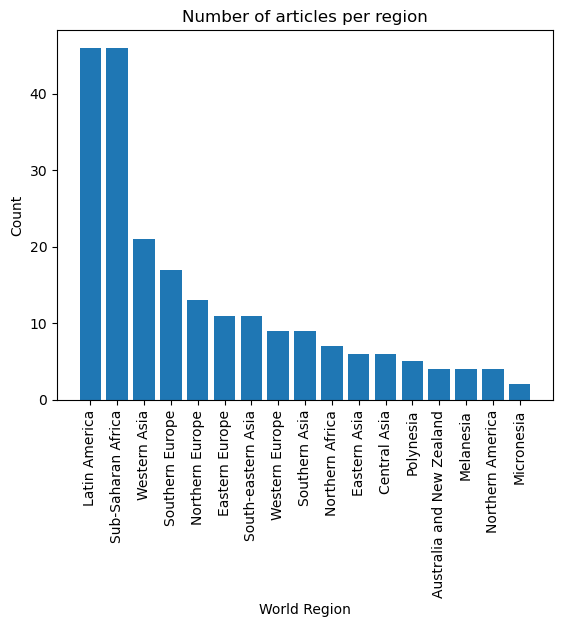

In [12]:
# Plotting the distribution of countries in the dataset based on their region.
countries_per_region = ((country_region_df.groupby('Region').count()).reset_index()).sort_values(by='Country', ascending=False)

plt.bar(countries_per_region['Region'], countries_per_region['Country'])
plt.xticks(rotation=90)
plt.title("Number of articles per region")
plt.xlabel("World Region")
plt.ylabel("Count")
plt.show()

# All countries (and a some more) that are recognized by the UN are included in our Dataset.

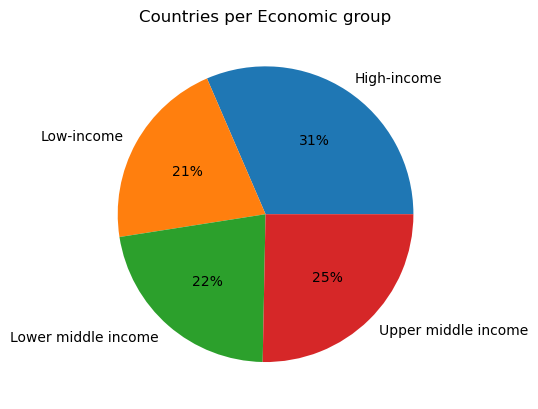

In [13]:
# Plotting the distribution of countries in the dataset based on their economic classification
countries_per_economie = (UN_countries_by_economies.groupby('Economic classification').count()).reset_index()
countries_per_economie.columns = ['Economic_classification', 'Country','Least Developed Countries (LDC)',
                                    'Land Locked Developing Countries (LLDC)','Small Island Developing States (SIDS)']
total_countries = countries_per_economie['Country'].sum()
countries_per_economie['percentage'] = countries_per_economie.apply(lambda row: row.Country / total_countries * 100, axis=1)

plt.pie(countries_per_economie['percentage'], labels=countries_per_economie['Economic_classification'], autopct='%1.f%%')
plt.title("Countries per Economic group")
plt.show()

# The countries are almost evenly distributed among the different income groups

### 2. Length of Wikipedia Articles

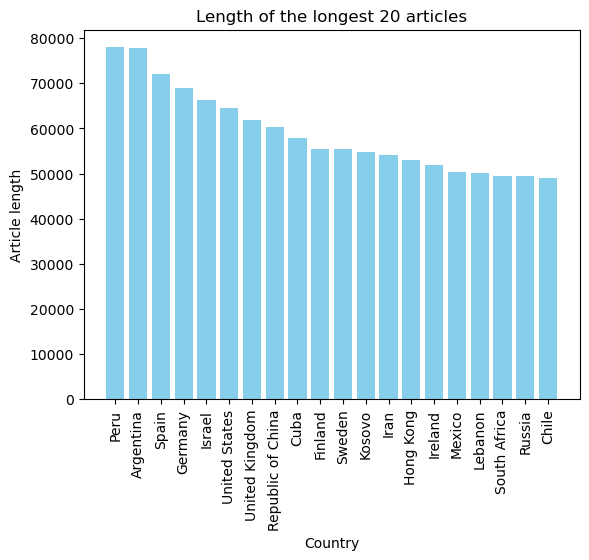

In [14]:
sorted_articles = plaintext_articles.sort_values(by='Article length', ascending=False)

plt.bar(sorted_articles.iloc[:20]['Country'], sorted_articles.iloc[:20]['Article length'], color='skyblue')
plt.xlabel('Country')
plt.ylabel('Article length')
plt.title('Length of the longest 20 articles')
# rotate x -> to be able to read
plt.xticks(rotation=90) 
plt.show()

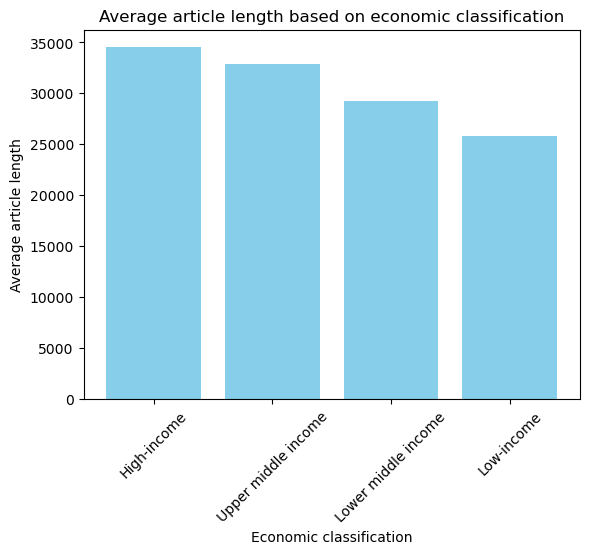

In [15]:
merged_df = pd.merge(plaintext_articles, UN_countries_by_economies, on='Country')
# Group by economic classification and calculate the mean of article length instead of sum
grouped_df = merged_df.groupby('Economic classification')['Article length'].mean().reset_index()
sorted_articles_by_economic_class = grouped_df.sort_values(by='Article length', ascending=False)
plt.bar(sorted_articles_by_economic_class['Economic classification'], sorted_articles_by_economic_class['Article length'], color='skyblue')
plt.xlabel('Economic classification')
plt.ylabel('Average article length')
plt.title('Average article length based on economic classification')
plt.xticks(rotation=45)

plt.show()

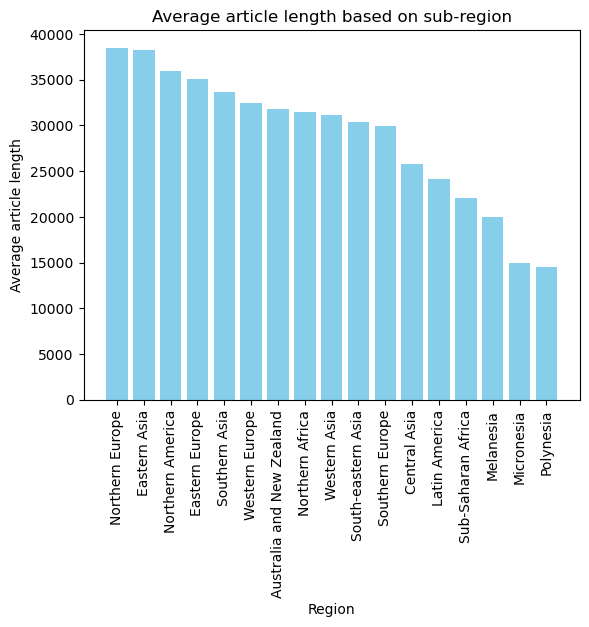

In [16]:
merged_df = pd.merge(country_region_df, plaintext_articles, on='Country')
# Group by economic classification and calculate the mean of article length instead of sum
grouped_df = merged_df.groupby('Region')['Article length'].mean().reset_index()
sorted_articles_by_economic_class = grouped_df.sort_values(by='Article length', ascending=False)
plt.bar(sorted_articles_by_economic_class['Region'], sorted_articles_by_economic_class['Article length'], color='skyblue')
plt.xlabel('Region')
plt.ylabel('Average article length')
plt.title('Average article length based on sub-region')
plt.xticks(rotation=90)

plt.show()

### 3. Number of hyperlinks

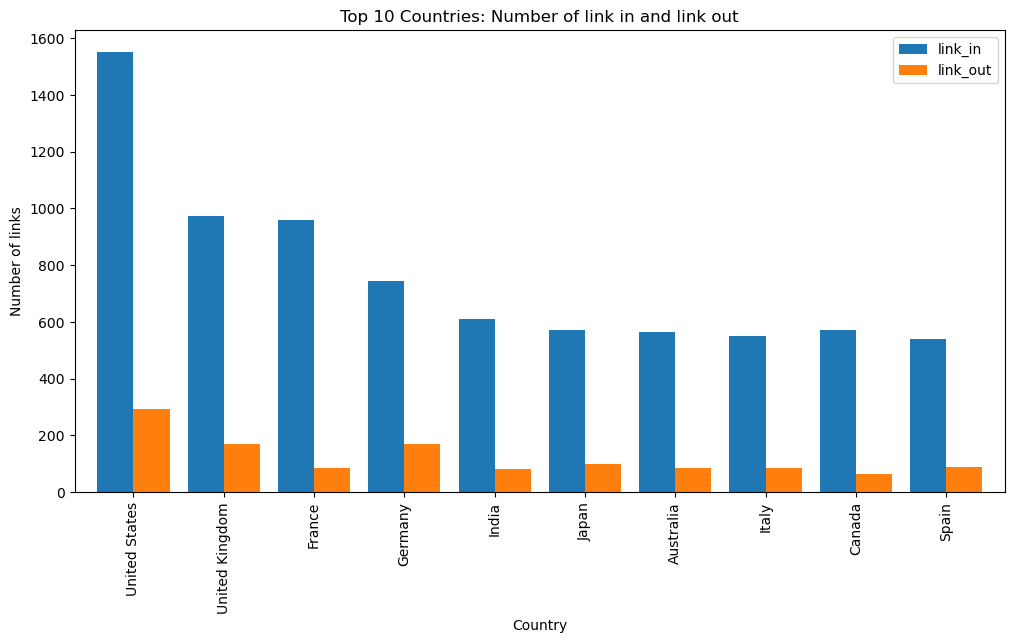

In [17]:
grouped_data = country_links_df.groupby('Country')[['link_in', 'link_out']].sum()
grouped_data['total_links'] = grouped_data['link_in'] + grouped_data['link_out']
grouped_data = grouped_data.sort_values(by='total_links', ascending=False)
top_10_countries = grouped_data.head(10)

fig, ax = plt.subplots(figsize=(12, 6))
top_10_countries[['link_in', 'link_out']].plot(kind='bar', ax=ax, width=0.8)
plt.xlabel('Country')
plt.ylabel('Number of links')
plt.title('Top 10 Countries: Number of link in and link out')
plt.show()

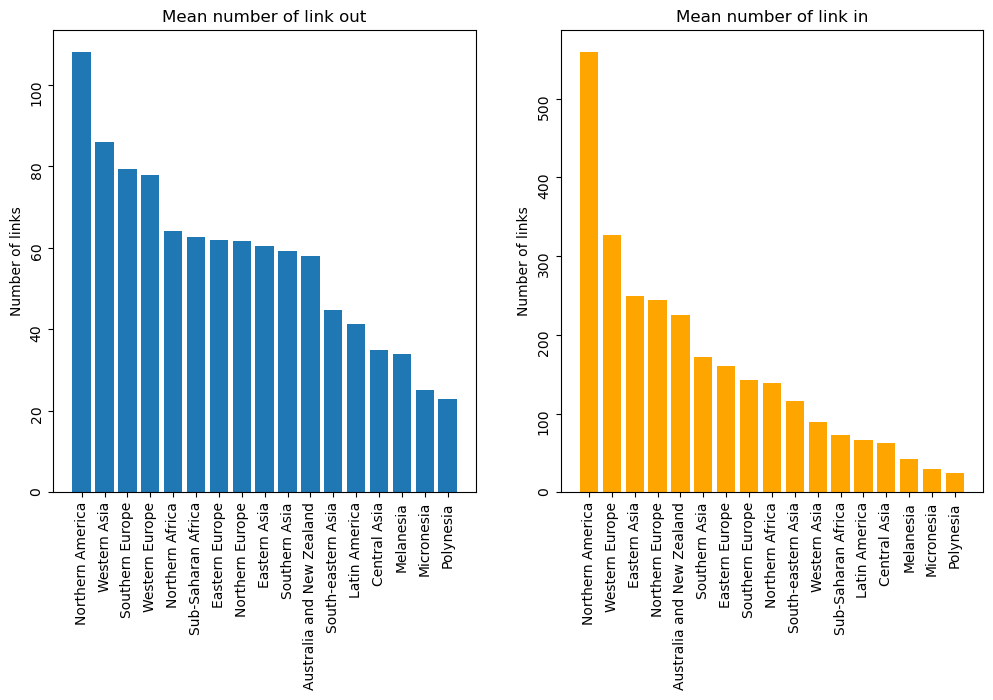

In [18]:
### Summary statistics for the number of in- and out- degrees of each region 

# Initialising empty dataframes
link_out_summary = pd.DataFrame()
link_in_summary = pd.DataFrame()

# Getting summary statistics for each region for in- and out- degrees
links_means = country_links_df[['link_out','link_in','Region']].groupby(['Region']).mean()
links_std = country_links_df[['link_out','link_in','Region']].groupby(['Region']).std()
links_max = country_links_df[['link_out','link_in','Region']].groupby(['Region']).max()
links_median = country_links_df[['link_out','link_in','Region']].groupby(['Region']).median()

for df, kind in [(links_means, 'mean'), (links_median, 'median'), (links_std, "std"), (links_max, 'max')]:
    link_out_summary[kind] = df['link_out']
    link_in_summary[kind] = df['link_in']

# df containing summary statistics
link_out_summary_df = (link_out_summary.reset_index()).sort_values(by='mean', ascending=False)
# df containing summary statistics
link_in_summary_df = (link_in_summary.reset_index()).sort_values(by='mean', ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.bar(link_out_summary_df['Region'], link_out_summary_df['mean'])
ax1.set_ylabel('Number of links')
ax1.set_title('Mean number of link out')
ax1.tick_params(labelrotation=90)

ax2.bar(link_in_summary_df['Region'], link_in_summary_df['mean'], color='orange')
ax2.set_ylabel('Number of links')
ax2.set_title('Mean number of link in')
ax2.tick_params(labelrotation=90)
plt.show()

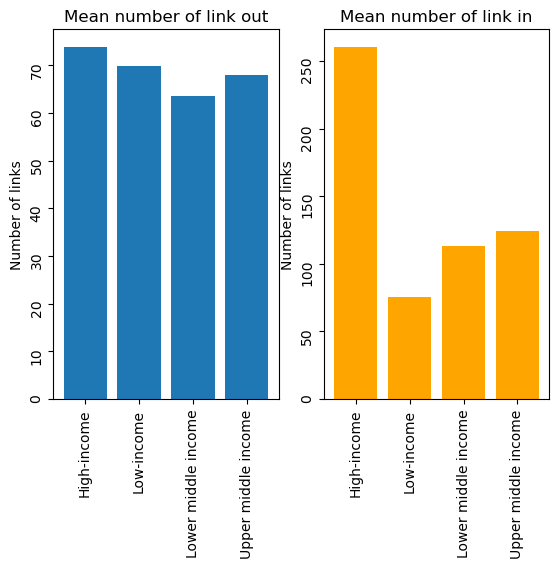

In [19]:
merged_df = country_links_df.merge(UN_countries_by_economies, how='left', on='Country')
merged_df = merged_df[['link_out', 'link_in','Economic classification']]
grouped_df = (merged_df.groupby('Economic classification').mean()).reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar(grouped_df['Economic classification'], grouped_df['link_out'])
ax1.set_ylabel('Number of links')
ax1.set_title('Mean number of link out')
ax1.tick_params(labelrotation=90)

ax2.bar(grouped_df['Economic classification'], grouped_df['link_in'], color='orange')
ax2.set_ylabel('Number of links')
ax2.set_title('Mean number of link in')
ax2.tick_params(labelrotation=90)
plt.show()

# While the number of links out is similiar (consistence, because also the mean article length is similiar),
# the differences in number of links in (other articles pointing to country articles) is big

### 4. Sentiment Analysis

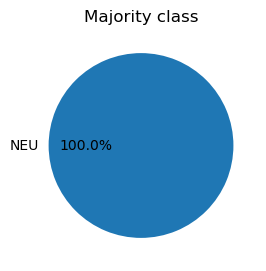

In [20]:
category_counts = sentiment_analysis_of_countries['Sentiment'].value_counts()
plt.figure(figsize=(3, 3))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Majority class')
plt.show()

# The majority class (= sentiment of the majority of paragraphs in an article) is neutral for all country articles

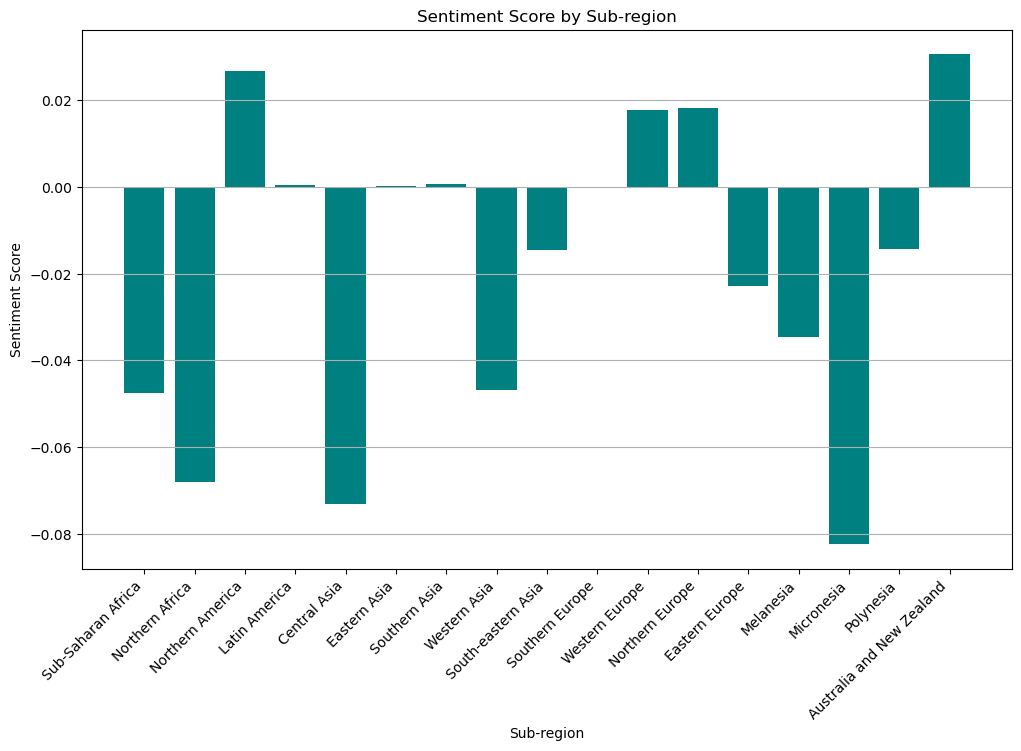

In [21]:
sa_to_plot = (pd.merge(sentiment_analysis_of_countries, country_region_df, how='left', on='Country')[['sentiment score', 'Region']].groupby('Region').mean()).reset_index()

sa_to_plot['Last Word to sort on'] = sa_to_plot['Region'].str.split().str[-1]
sa_to_plot = sa_to_plot.sort_values(by='Last Word to sort on')
sa_to_plot.drop('Last Word to sort on', axis=1, inplace=True)

# Plot
plt.figure(figsize=(12, 7))
plt.bar(sa_to_plot['Region'], sa_to_plot['sentiment score'], color='teal')
plt.title('Sentiment Score by Sub-region')
plt.xlabel('Sub-region')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

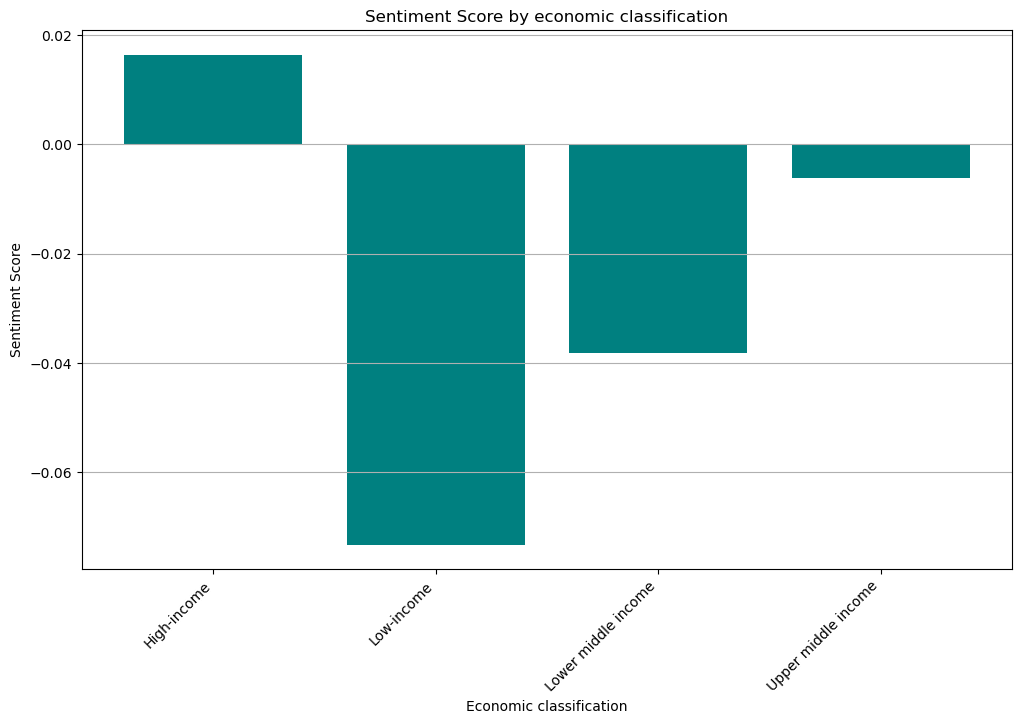

In [22]:
sa_to_plot = (pd.merge(sentiment_analysis_of_countries, UN_countries_by_economies, how='left', left_on='Country', right_on='Country')[['sentiment score', 'Economic classification']].groupby('Economic classification').mean()).reset_index()

# Plot
plt.figure(figsize=(12, 7))
plt.bar(sa_to_plot['Economic classification'], sa_to_plot['sentiment score'], color='teal')
plt.title('Sentiment Score by economic classification')
plt.xlabel('Economic classification')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

### 5. Population size

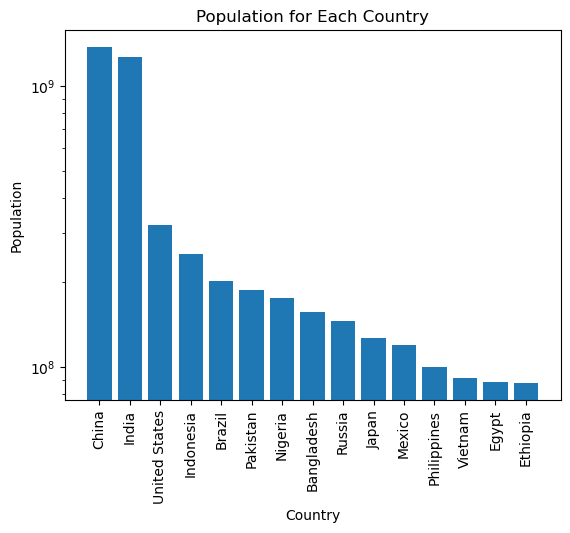

In [23]:
sorted_pop = UN_countries_by_population.sort_values(by='Value', ascending=False)
sorted_pop = sorted_pop.merge(country_region_df, how = 'left', on = 'Country')
sorted_pop = sorted_pop.merge(UN_countries_by_economies, how = 'left', on = 'Country')
sorted_pop = sorted_pop.merge(plaintext_articles, how = 'left', on = 'Country')
sorted_pop = sorted_pop.merge(country_links_df, how = 'left', on = 'Country')
sorted_pop.columns = ['Country', 'Year', 'Value', 'Region', 'LDC', 'LLDC', 'SIDS',
       'Economic_classification', 'Article_content', 'Article_length',
       'link_out', 'link_in', 'Region_y']
sorted_pop = sorted_pop[['Country', 'Value', 'Region','Economic_classification', 'Article_length', 'link_out', 'link_in']] 

top_15_countries = pd.DataFrame(sorted_pop.head(15))

plt.bar(top_15_countries['Country'], top_15_countries['Value'])
plt.xlabel('Country')
plt.ylabel('Population')
plt.title('Population for Each Country')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

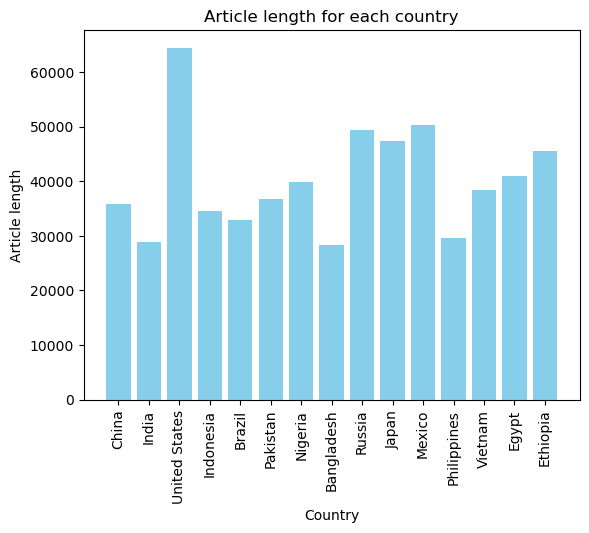

In [24]:
plt.bar(top_15_countries['Country'], top_15_countries['Article_length'], color='skyblue')
plt.xlabel('Country')
plt.ylabel('Article length')
plt.title('Article length for each country')
# rotate x -> to be able to read
plt.xticks(rotation=90) 
plt.show()

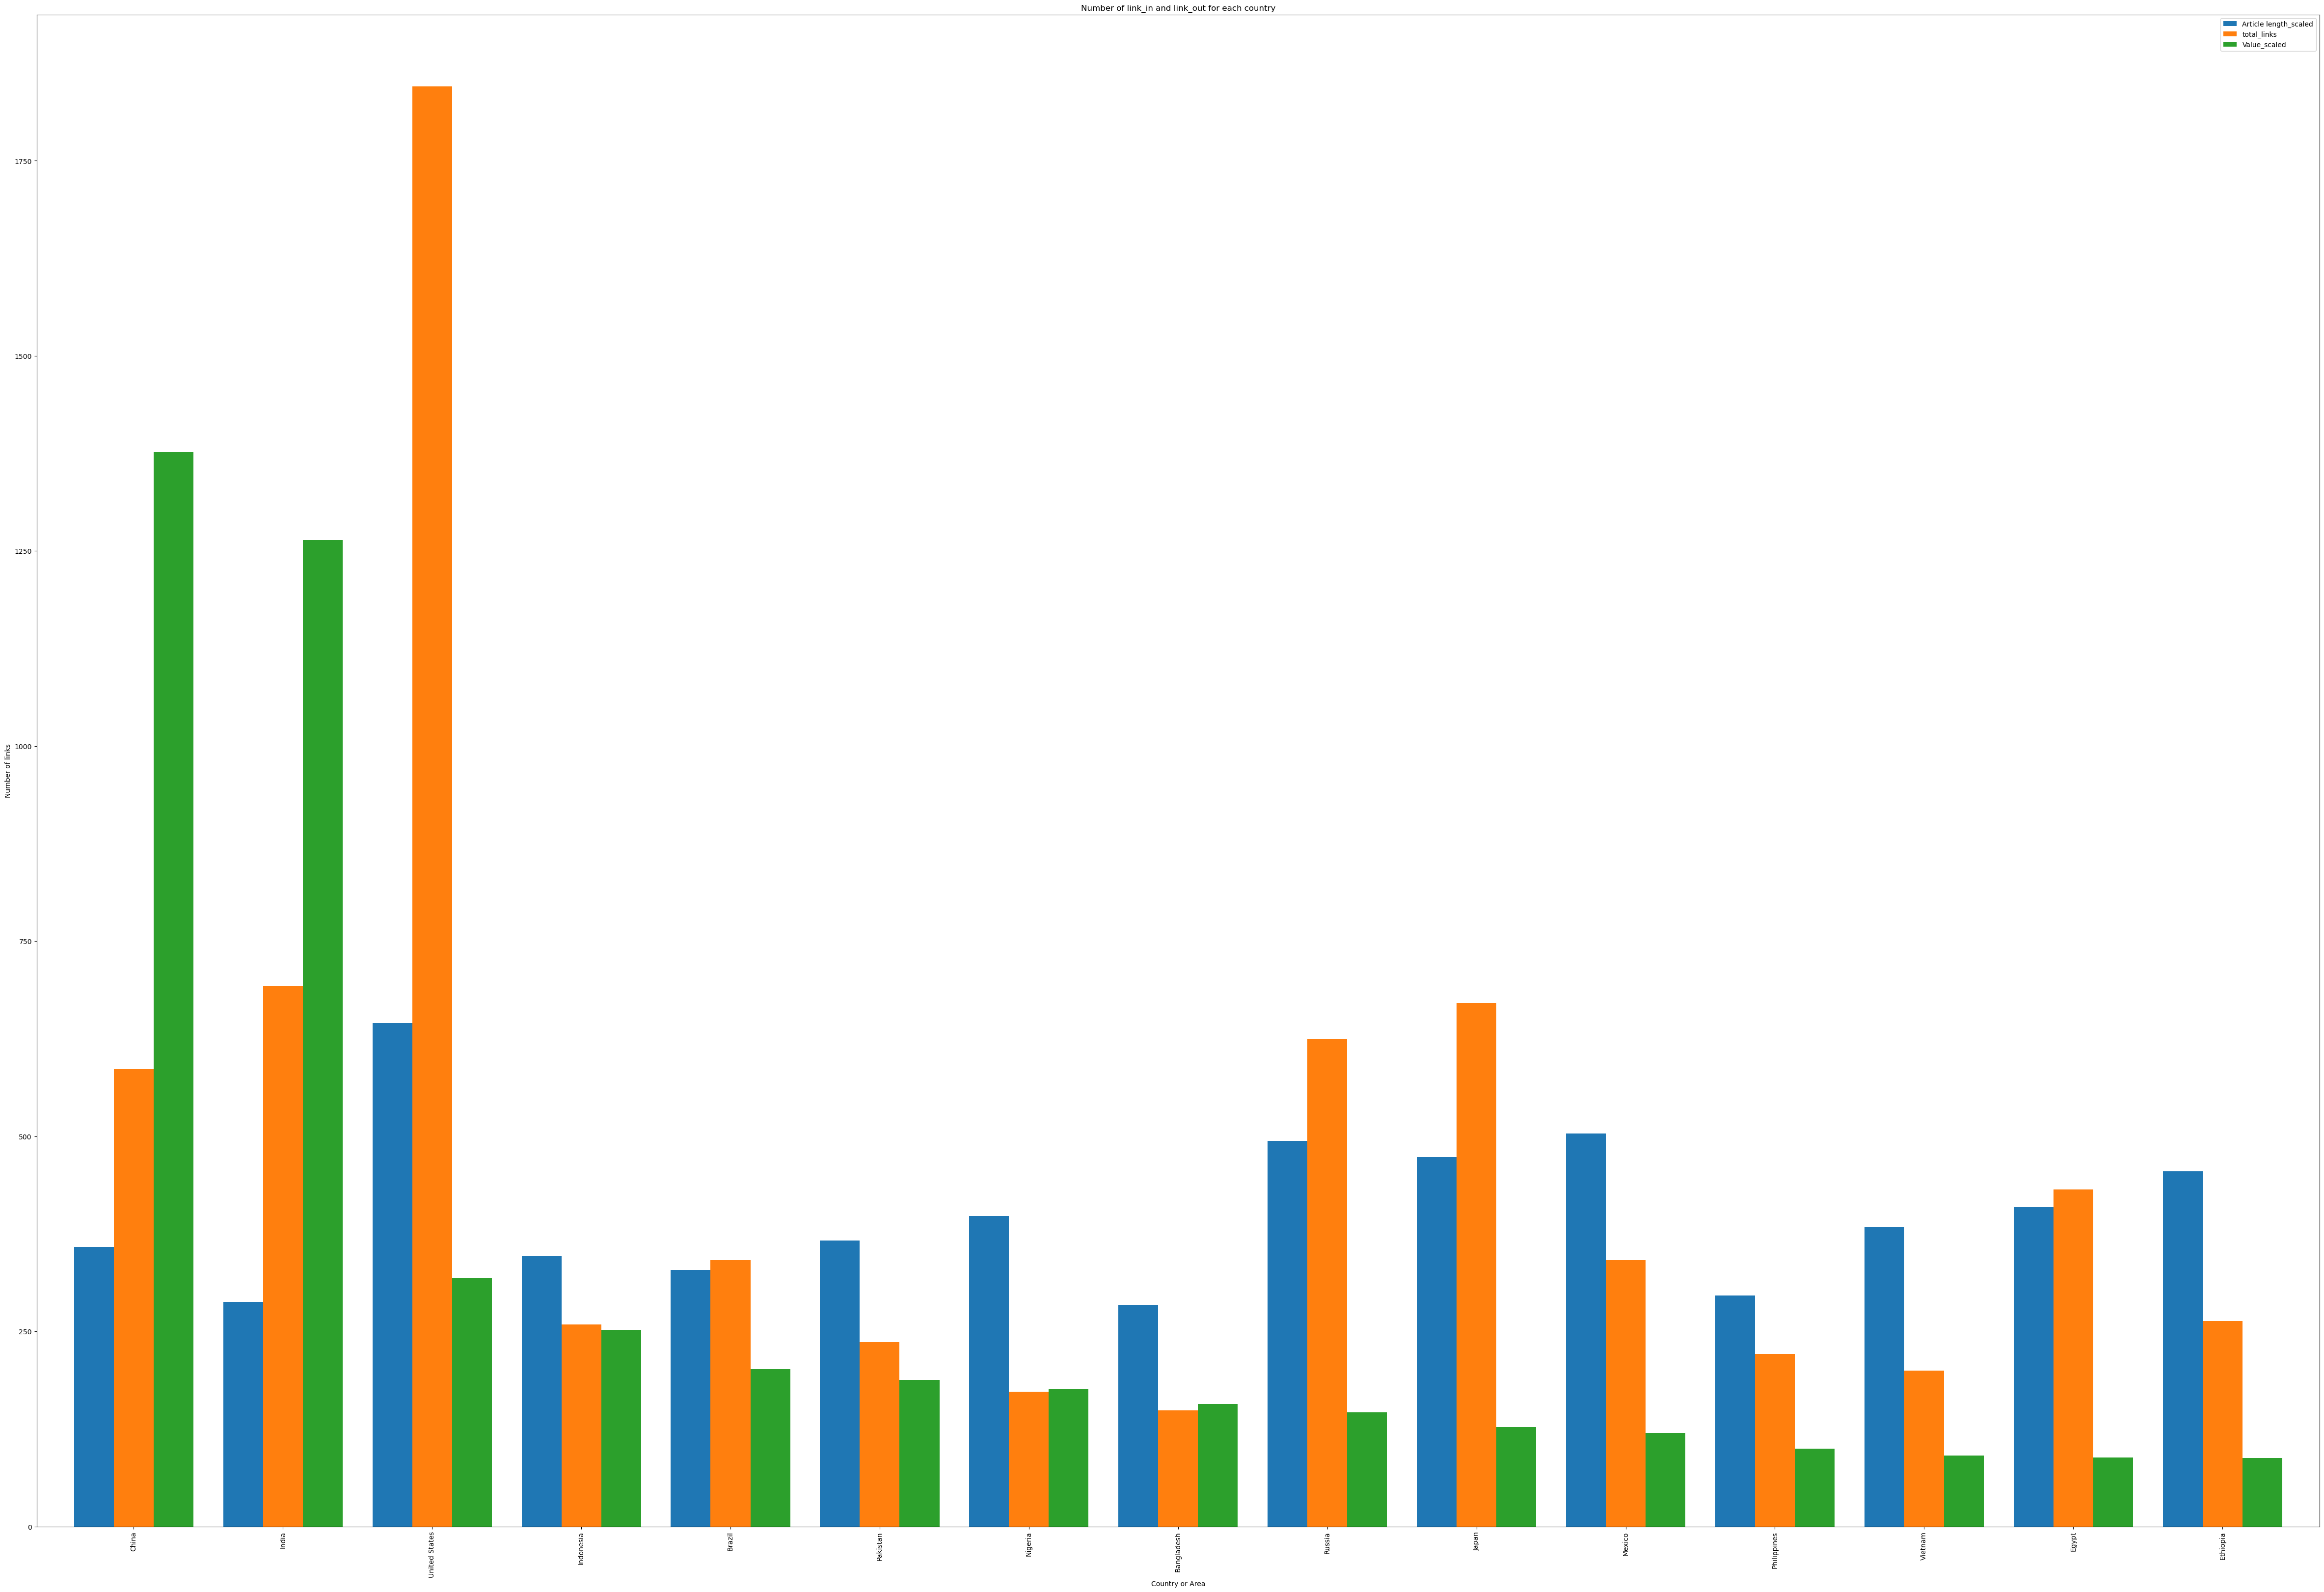

In [25]:
# Plot to show population in Millions (scaled value can change), Article length in 100 (scaled value can change)
# and the number of links (in + out)

top_15_countries_for_plot = top_15_countries.copy()
top_15_countries_for_plot['total_links'] = top_15_countries_for_plot.apply(
    lambda row: row.link_out + row.link_in, axis = 1
)
top_15_countries_for_plot['Value_scaled'] = top_15_countries_for_plot.apply(
    lambda row: row.Value / 1000000, axis = 1 #### scaling factor chan be changed
)
top_15_countries_for_plot['Article length_scaled'] = top_15_countries_for_plot.apply(
    lambda row: row.Article_length / 100, axis = 1 #### scaling factor chan be changed
)
top_15_countries_for_plot.set_index('Country', inplace=True)

fig, ax = plt.subplots(figsize=(60, 40))

top_15_countries_for_plot[['Article length_scaled', 'total_links', 'Value_scaled']].plot(kind='bar', ax=ax, width=0.8)
xticks = ['']
plt.xlabel('Country or Area')
plt.ylabel('Number of links')
plt.title('Number of link_in and link_out for each country')
plt.legend()

plt.show()

# Data Analysis - Part 2:

Descriptive statistics and naive statistical analysis about the behaviour of the players

1. Ratio of finished pathways, where articles* are the target (includes the creation of two helper dataframes, region_paths_df and econ_paths_df)
2. Length of the pathway taken respectively the time needed, where articles* are the target
3. How often does an article* appear in a pathway where it is neither the start nor the traget?

### 1. Ratio of finished pathways

In [26]:
region_completed_count = country_path_overview[['Region','completed','target']].groupby(['Region','completed']).count()
region_count = country_path_overview[['Region','target']].groupby(['Region']).count()

region_paths_df = pd.DataFrame(columns = ['Region', 'Status', 'Proportion'])
index = 0
for region, completion in region_completed_count.index:
    proportion = region_completed_count.loc[(region, completion)] / region_count.loc[region]
    if completion:
        status = 'finished'
    else:
         status = 'unfinished'
    new_row = {'Region': region, 'Status': status, 'Proportion': round(proportion.values[0]*100,1)}
    region_paths_df.loc[index] = new_row
    index += 1

region_paths_df.head()

,Region,Status,Proportion
0,Australia and New Zealand,unfinished,19.0
1,Australia and New Zealand,finished,81.0
2,Central Asia,unfinished,18.1
3,Central Asia,finished,81.9
4,Eastern Asia,unfinished,7.9


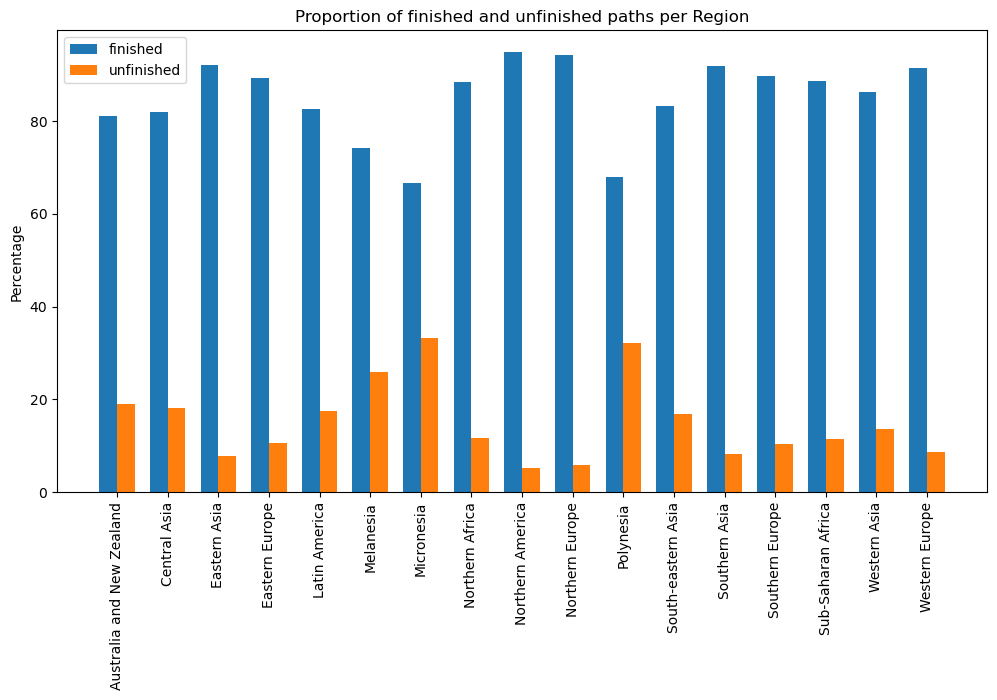

In [27]:
labels = region_paths_df['Region'].unique()
finished_means = region_paths_df[region_paths_df['Status'] == 'finished']['Proportion']
unfinished_means = region_paths_df[region_paths_df['Status'] == 'unfinished']['Proportion']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, finished_means, width, label='finished')
rects2 = ax.bar(x + width/2, unfinished_means, width, label='unfinished')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Proportion of finished and unfinished paths per Region')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()
plt.show()

In [28]:
region_paths_df_updated = pd.DataFrame({
    'Region': labels,
    'Finished Games': finished_means.values,
    'Unfinished Games': unfinished_means.values
})

fig = px.bar(region_paths_df_updated, y='Region', x=['Finished Games', 'Unfinished Games'], orientation='h', barmode='stack',
             labels={'Values1': 'Trace 1', 'Values2': 'Trace 2'},
             title='Stacked Horizontal Bar Chart')

fig.update_layout(
    xaxis=dict(range=[0, 100]),
    height = 600,
    title='Proportion of finished and unfinished games played by Region', 
    xaxis_title='Proportion of finished/unfinished games (%)',
    yaxis_title='Region',
    title_x = 0.5,
    title_y = 0.925,
    legend_title_text = ""
)

fig.show()


In [29]:
econ_completed_count = country_path_overview[['Economic classification','completed','target']].groupby(['Economic classification','completed']).count()
econ_count = country_path_overview[['Economic classification','target']].groupby(['Economic classification']).count()

econ_paths_df = pd.DataFrame(columns = ['Economic classification', 'Status', 'Proportion'])
index = 0
for econ, completion in econ_completed_count.index:
    proportion = econ_completed_count.loc[(econ, completion)] / econ_count.loc[econ]
    if completion:
        status = 'finished'
    else:
         status = 'unfinished'
    # print(f"Proportion of {status} paths with {region} as target: {round(proportion.values[0]*100,4)}%")
    new_row = {'Economic classification': econ, 'Status': status, 'Proportion': round(proportion.values[0]*100,1)}
    econ_paths_df.loc[index] = new_row
    index += 1

econ_paths_df

,Economic classification,Status,Proportion
0,High-income,unfinished,9.3
1,High-income,finished,90.7
2,Low-income,unfinished,10.6
3,Low-income,finished,89.4
4,Lower middle income,unfinished,13.0
5,Lower middle income,finished,87.0
6,Upper middle income,unfinished,10.4
7,Upper middle income,finished,89.6


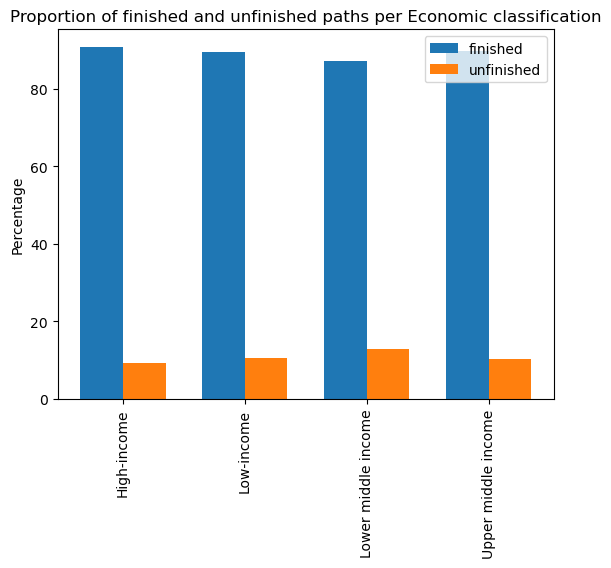

In [30]:
labels = econ_paths_df['Economic classification'].unique()
finished_means = econ_paths_df[econ_paths_df['Status'] == 'finished']['Proportion']
unfinished_means = econ_paths_df[econ_paths_df['Status'] == 'unfinished']['Proportion']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, finished_means, width, label='finished')
rects2 = ax.bar(x + width/2, unfinished_means, width, label='unfinished')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Proportion of finished and unfinished paths per Economic classification')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()
plt.show()

In [31]:
labels = econ_paths_df['Economic classification'].unique()
finished_means = econ_paths_df[econ_paths_df['Status'] == 'finished']['Proportion']
unfinished_means = econ_paths_df[econ_paths_df['Status'] == 'unfinished']['Proportion']

region_paths_df_updated = pd.DataFrame({
    'Region': labels,
    'Finished Games': finished_means.values,
    'Unfinished Games': unfinished_means.values
})

fig = px.bar(region_paths_df_updated, y='Region', x=['Finished Games', 'Unfinished Games'], orientation='h', barmode='stack',
             labels={'Values1': 'Trace 1', 'Values2': 'Trace 2'},
             title='Stacked Horizontal Bar Chart')

fig.update_layout(
    xaxis=dict(range=[0, 100]),
    height = 600,
    title='Proportion of finished and unfinished games played by Region', 
    xaxis_title='Proportion of finished/unfinished games (%)',
    yaxis_title='Region',
    title_x = 0.5,
    title_y = 0.925,
    legend_title_text = ""
)

fig.show()


### 2. Length and time needed TODO: Median or Means?

In [32]:
# Create helper dataframes of the finished pathways only and group them by Region resp. Economic classification and shortest paths

regions_paths = country_path_overview[['Region','shortest_distance','game_path']][country_path_overview['completed']==True].groupby(by=['Region','shortest_distance']).median().reset_index()
econ_paths = country_path_overview[['Economic classification','shortest_distance','game_path']][country_path_overview['completed']==True].groupby(by=['Economic classification','shortest_distance']).median().reset_index()

regions_paths_1 = regions_paths[regions_paths['shortest_distance'] == 1]
regions_paths_2 = regions_paths[regions_paths['shortest_distance'] == 2]
regions_paths_3 = regions_paths[regions_paths['shortest_distance'] == 3]
regions_paths_4 = regions_paths[regions_paths['shortest_distance'] == 4]

econ_paths_1 = econ_paths[econ_paths['shortest_distance'] == 1]
econ_paths_2 = econ_paths[econ_paths['shortest_distance'] == 2]
econ_paths_3 = econ_paths[econ_paths['shortest_distance'] == 3]
econ_paths_4 = econ_paths[econ_paths['shortest_distance'] == 4]

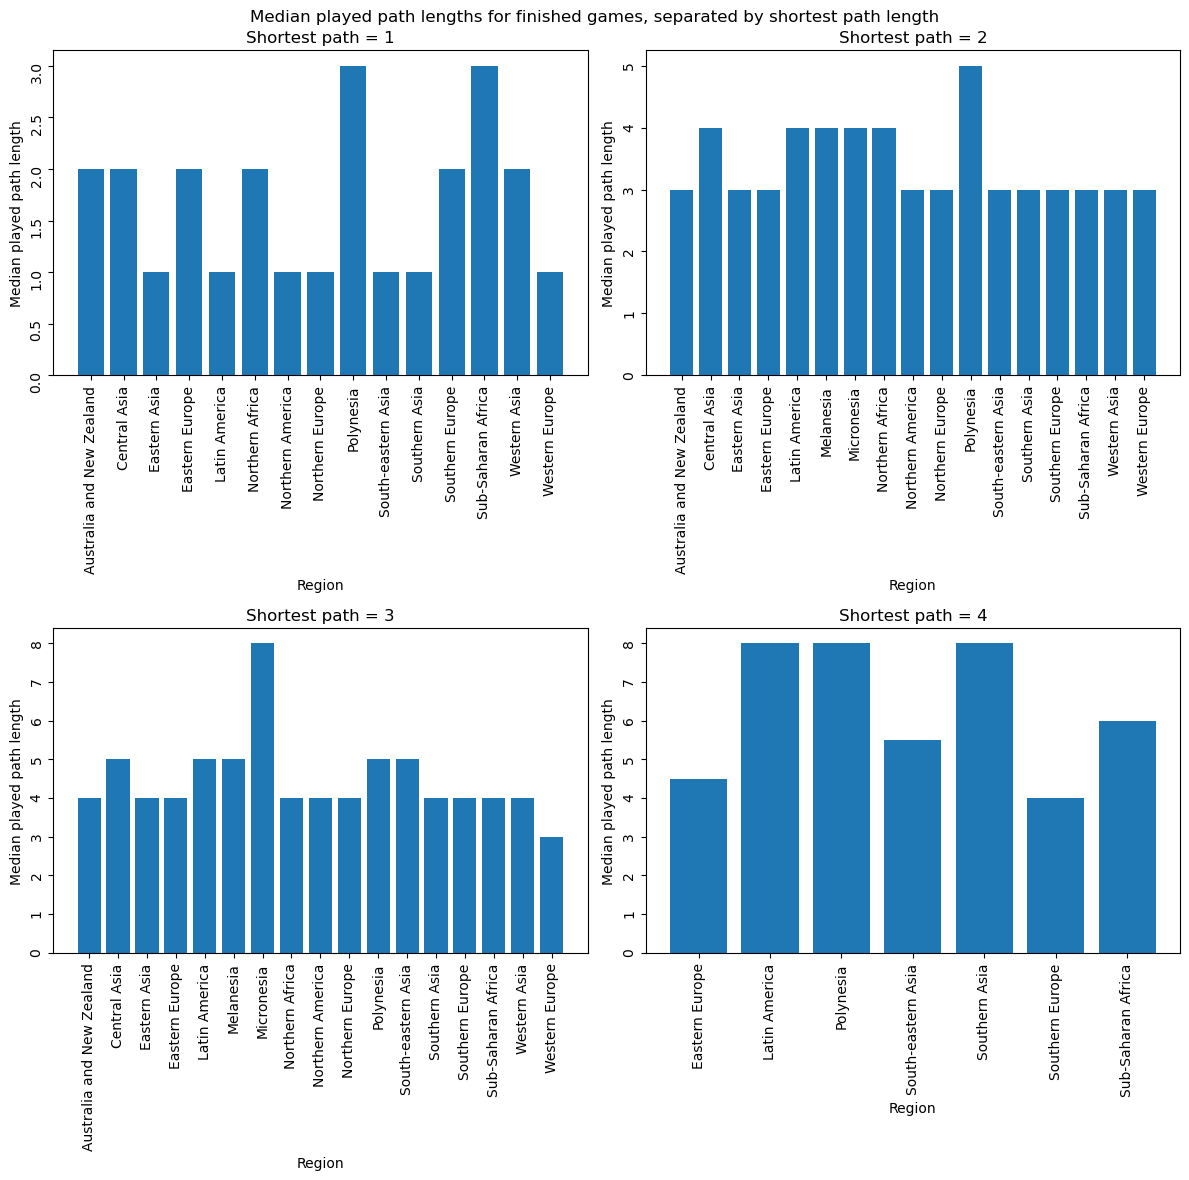

In [33]:
figs, axs = plt.subplots(2,2, figsize=(12,12))

figs.suptitle("Median played path lengths for finished games, separated by shortest path length")

axs[0,0].bar(regions_paths_1['Region'], regions_paths_1['game_path'])
axs[0,0].set_title("Shortest path = 1")
axs[0,0].set_xlabel("Region")
axs[0,0].set_ylabel("Median played path length")
axs[0,0].tick_params(labelrotation=90)

axs[0,1].bar(regions_paths_2['Region'], regions_paths_2['game_path'])
axs[0,1].set_title("Shortest path = 2")
axs[0,1].set_xlabel("Region")
axs[0,1].set_ylabel("Median played path length")
axs[0,1].tick_params(labelrotation=90)

axs[1,0].bar(regions_paths_3['Region'], regions_paths_3['game_path'])
axs[1,0].set_title("Shortest path = 3")
axs[1,0].set_xlabel("Region")
axs[1,0].set_ylabel("Median played path length")
axs[1,0].tick_params(labelrotation=90)

axs[1,1].bar(regions_paths_4['Region'], regions_paths_4['game_path'])
axs[1,1].set_title("Shortest path = 4")
axs[1,1].set_xlabel("Region")
axs[1,1].set_ylabel("Median played path length")
axs[1,1].tick_params(labelrotation=90)

plt.tight_layout()
plt.show()

# For shortest path = 4 some regions don't have a value, because all their targets have a shortest length of max. 3

In [34]:
import plotly.graph_objects as go

import pandas as pd

# load dataset
df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/volcano.csv")

# create figure
fig = go.Figure()

# Add surface trace
fig.add_trace(go.Bar(x=regions_paths_1['Region'], y=regions_paths_1['game_path'], visible=True, name=''))
fig.add_trace(go.Bar(x=regions_paths_2['Region'], y=regions_paths_2['game_path'], visible=False, name=''))
fig.add_trace(go.Bar(x=regions_paths_3['Region'], y=regions_paths_3['game_path'], visible=False, name=''))
fig.add_trace(go.Bar(x=regions_paths_4['Region'], y=regions_paths_4['game_path'], visible=False, name=''))

# Update plot sizing
fig.update_layout(
    width=800,
    height=900,
    autosize=False,
    margin=dict(t=0, b=0, l=0, r=0),
    template="plotly_white",
)

# Update 3D scene options
fig.update_scenes(
    aspectratio=dict(x=1, y=1, z=0.7),
    aspectmode="manual"
)

fig.update_layout(
    height = 700,
    width = 1000,
    margin=dict(b=100, t=150, l=80, r=80),
    title="Median finished game length for games with shortest path of 1", 
    xaxis_title='Region',
    yaxis_title='Player path length',
    title_x = 0.5,
    title_y = 0.925,
    legend_title_text = "",

    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label="1",
                     method="update",
                     args=[{"visible": [True, False, False, False]},
                           {"title": "Median finished game length for games with shortest path of 1"}]),
                dict(label="2",
                     method="update",
                     args=[{"visible": [False, True, False, False]},
                           {"title": "Median finished game length for games with shortest path of 2"}]),
                dict(label="3",
                     method="update",
                     args=[{"visible": [False, False, True, False]},
                           {"title": "Median finished game length for games with shortest path of 3"}]),
                dict(label="4",
                     method="update",
                     args=[{"visible": [False, False, False, True]},
                           {"title": "Median finished game length for games with shortest path of 4"}]),
            ]),
            showactive=True,
            x=0.16,
            xanchor="left",
            y=1.09,
            yanchor="top"
        )
    ])

# Add annotation
fig.update_layout(
    annotations=[
        dict(text="Shortest Path Length:", showarrow=False,
        x=0, y=1.08, yref="paper", align="left")
    ]
)

fig.show()


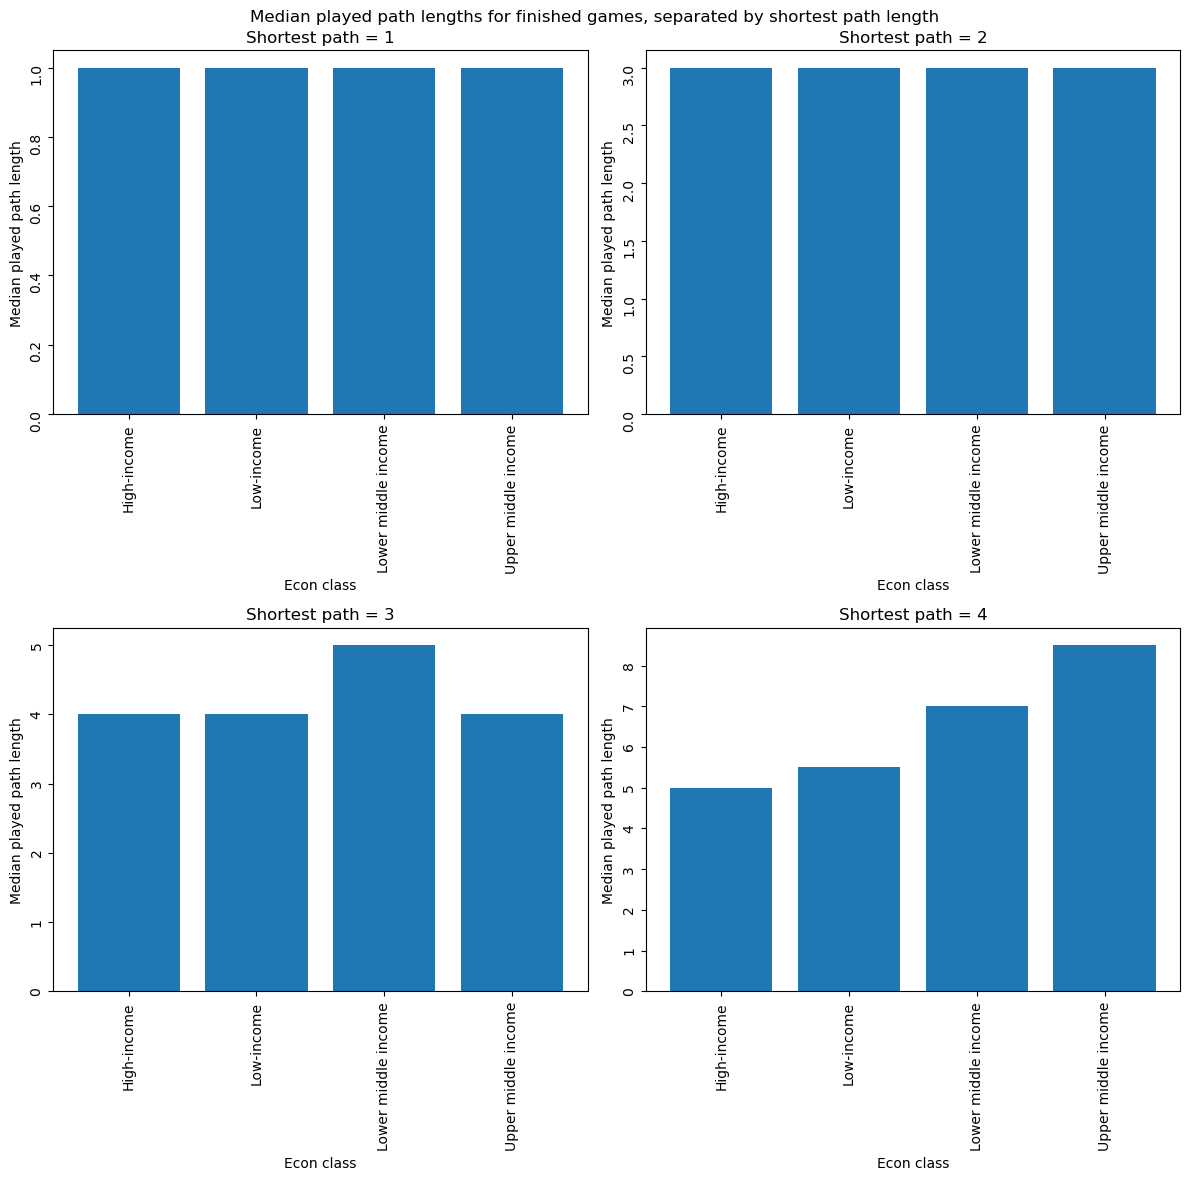

In [35]:
figs, axs = plt.subplots(2,2, figsize=(12,12))

figs.suptitle("Median played path lengths for finished games, separated by shortest path length")

axs[0,0].bar(econ_paths_1['Economic classification'], econ_paths_1['game_path'])
axs[0,0].set_title("Shortest path = 1")
axs[0,0].set_xlabel("Econ class")
axs[0,0].set_ylabel("Median played path length")
axs[0,0].tick_params(labelrotation=90)

axs[0,1].bar(econ_paths_2['Economic classification'], econ_paths_2['game_path'])
axs[0,1].set_title("Shortest path = 2")
axs[0,1].set_xlabel("Econ class")
axs[0,1].set_ylabel("Median played path length")
axs[0,1].tick_params(labelrotation=90)

axs[1,0].bar(econ_paths_3['Economic classification'], econ_paths_3['game_path'])
axs[1,0].set_title("Shortest path = 3")
axs[1,0].set_xlabel("Econ class")
axs[1,0].set_ylabel("Median played path length")
axs[1,0].tick_params(labelrotation=90)

axs[1,1].bar(econ_paths_4['Economic classification'], econ_paths_4['game_path'])
axs[1,1].set_title("Shortest path = 4")
axs[1,1].set_xlabel("Econ class")
axs[1,1].set_ylabel("Median played path length")
axs[1,1].tick_params(labelrotation=90)

plt.tight_layout()
plt.show()

### 3. Frequency of article C's involvement in pathways where it was neither the start nor the target

In [36]:
### Create similar Dataframe than paths_finished in Data wrangling part, but add whole paths

# expand the finished paths
paths_finished_task3 = paths_finished_load.copy()
path_fin_task3 = paths_finished_task3.assign(source=paths_finished_task3['path'].apply(lambda x: hlp.seperate_path(x)[0]),
                           target=paths_finished_task3['path'].apply(lambda x: hlp.seperate_path(x)[1]),
                           game_path=paths_finished_task3['path'].apply(lambda x: hlp.seperate_path(x)[2]),
                           completed=True,
                           paths=paths_finished_task3['path'])

# expand the unfinished paths
paths_unfinished_task3 = paths_unfinished_load.copy()
path_unfin_task3 = paths_unfinished_task3.assign(source=paths_unfinished_task3['path'].apply(lambda x: hlp.seperate_path(x)[0]),
                             failure_article=paths_unfinished_task3['path'].apply(lambda x: hlp.seperate_path(x)[1]),
                             game_path=paths_unfinished_task3['path'].apply(lambda x: hlp.seperate_path(x)[2]),
                             completed=False,
                             target=paths_unfinished_task3["target"],
                             paths=paths_unfinished_task3['path'])

# construct a new dataframe: path_overview_task3
path_overview_task3 = pd.concat([path_fin_task3, path_unfin_task3], ignore_index=True)[["source", "target",  "hashedIpAddress", "timestamp",
                                                                                        "durationInSec", "game_path","completed", "rating", "type", "paths"]]

# United_States -> United States (IMPORTANT: Don't do it here)

# Split "paths" in path_overview2
path_overview_task3['paths'] = path_overview_task3['paths'].str.replace(';',' ')

display(path_overview_task3)

,source,target,hashedIpAddress,timestamp,durationInSec,game_path,completed,rating,type,paths
0,14th_century,African_slave_trade,6a3701d319fc3754,1297740409,166,8,True,NaN,NaN,14th_century 15th_century 16th_century Pacific...
1,14th_century,African_slave_trade,3824310e536af032,1344753412,88,4,True,3.0,NaN,14th_century Europe Africa Atlantic_slave_trad...
2,14th_century,African_slave_trade,415612e93584d30e,1349298640,138,7,True,NaN,NaN,14th_century Niger Nigeria British_Empire Slav...
3,14th_century,Greece,64dd5cd342e3780c,1265613925,37,3,True,NaN,NaN,14th_century Renaissance Ancient_Greece Greece
4,14th_century,John_F._Kennedy,015245d773376aab,1366730828,175,6,True,3.0,NaN,14th_century Italy Roman_Catholic_Church HIV R...
...,...,...,...,...,...,...,...,...,...,...
76188,Franz_Kafka,Cholera,109ed71f571d86e9,1389787605,180,7,False,NaN,restart,Franz_Kafka Tuberculosis World_Health_Organiza...
76189,Modern_history,Hollandic,232f992e57d43e8d,1389787697,6,0,False,NaN,restart,Modern_history
76190,Computer_programming,The_Beatles,2e09a7224600a7cd,1389798400,1900,4,False,NaN,timeout,Computer_programming Linguistics Culture Popul...
76191,Jamaica,Alan_Turing,60af9e2138051b96,1389799481,1903,3,False,NaN,timeout,Jamaica United_Kingdom World_War_II Battle_of_...


In [37]:
# Count frequecy where article C is in a path (but is not start/target)
country_counts = {}

# Get list of all countries to iterate through
countries = plaintext_articles['Country'].str.replace(" ", "_")

for _, row in path_overview_task3.iterrows():
    articles = row['paths'].split()
    for country in countries:
        # check it is not target
        if country in articles and country != row['source'] and country != row['target']:
            # Count occurrences of the country in the paths
            count = articles.count(country)

            # update dict
            country_counts.setdefault(country, 0)
            country_counts[country] += count

# Create Dataframe and 
# Rename: United_States -> United States (important before merging) and
# add Region and Economic classification information
country_counts_df = pd.DataFrame(list(country_counts.items()), columns=['Country', 'Count'])
country_counts_df['Country'] = country_counts_df['Country'].str.replace('_',' ')
country_counts_df = country_counts_df.sort_values(by='Count', ascending=False)
country_counts_df = country_counts_df.merge(country_region_df, on = 'Country', how = 'left')
country_counts_df = country_counts_df.merge(UN_countries_by_economies[['Country', 'Economic classification']], on = 'Country', how = 'left')

display(country_counts_df)


,Country,Count,Region,Economic classification
0,United States,12366,Northern America,High-income
1,United Kingdom,5278,Northern Europe,High-income
2,France,2201,Western Europe,High-income
3,Germany,2121,Western Europe,High-income
4,India,1722,Southern Asia,Lower middle income
...,...,...,...,...
213,Kosovo,2,Eastern Europe,NaN
214,Serbia and Montenegro,1,Southern Europe,Upper middle income
215,South Ossetia,1,Western Asia,NaN
216,Turkish Republic of Northern Cyprus,1,Southern Europe,NaN


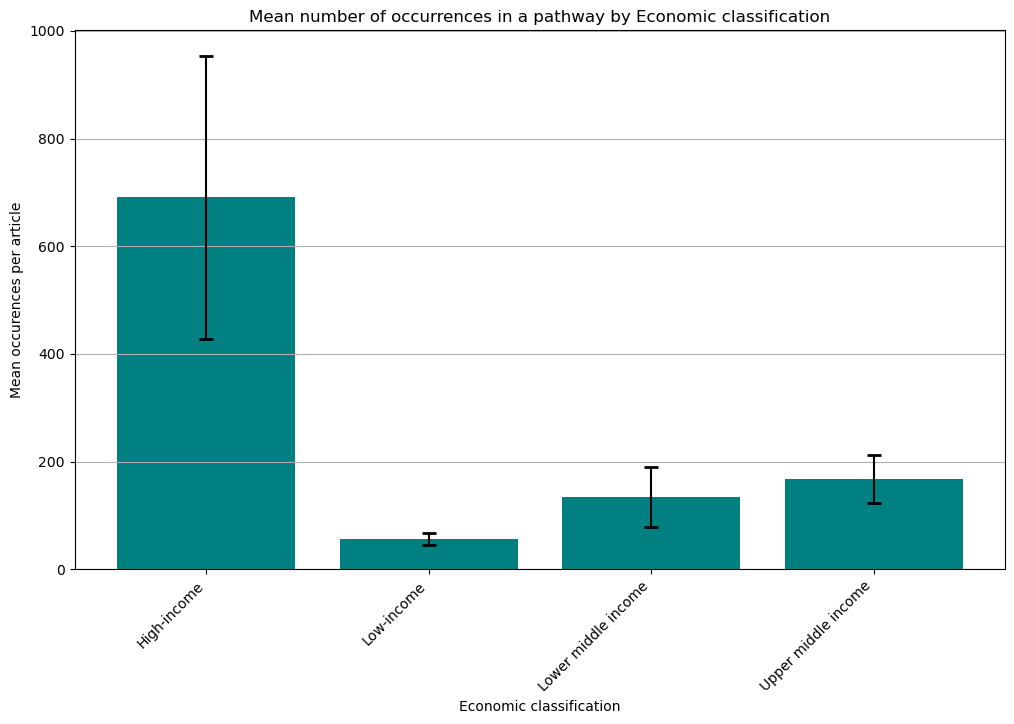

In [38]:
cc_to_plot = country_counts_df[['Count', 'Economic classification']].groupby('Economic classification').mean().reset_index()
cc_std = country_counts_df[['Count', 'Economic classification']].groupby('Economic classification').std().reset_index()
cc_counts = country_counts_df[['Count', 'Economic classification']].groupby('Economic classification').count().reset_index()
cc_se = cc_std['Count'].values/np.sqrt(cc_counts['Count'].values)
# Plot
plt.figure(figsize=(12, 7))
plt.bar(cc_to_plot['Economic classification'], cc_to_plot['Count'], color='teal')
plt.title('Mean number of occurrences in a pathway by Economic classification')
plt.xlabel('Economic classification')
plt.ylabel('Mean occurences per article')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

plt.errorbar(cc_to_plot['Economic classification'], cc_to_plot['Count'], yerr=cc_se, fmt='none', ecolor='black', capsize=5, capthick=2)


plt.show()

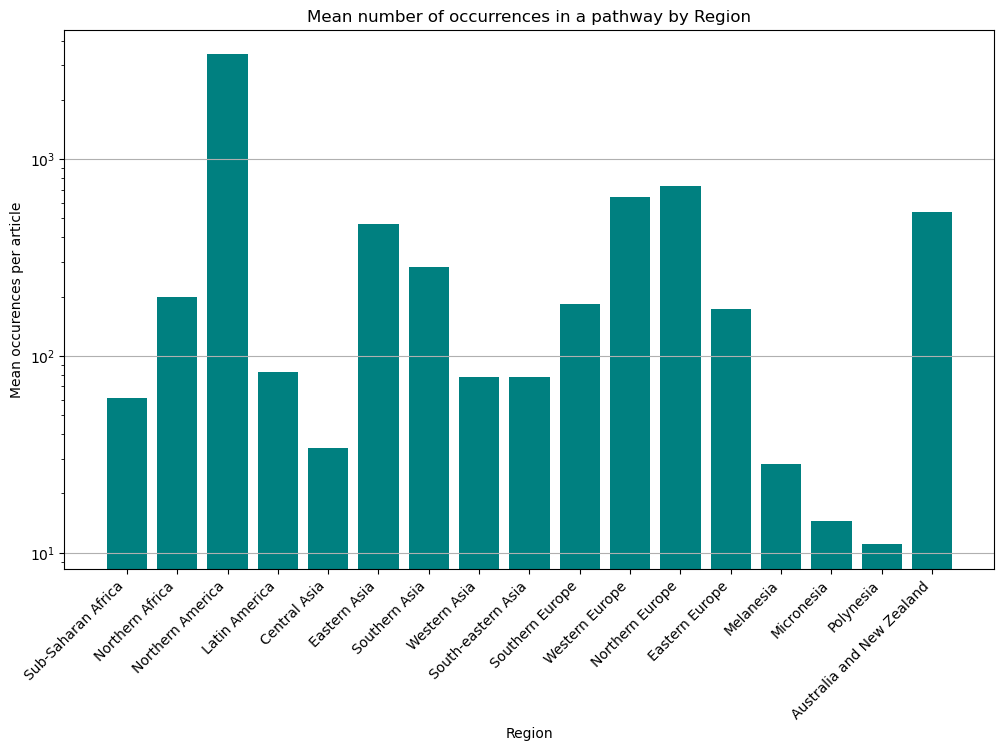

In [39]:
cc_to_plot = country_counts_df[['Count', 'Region']].groupby('Region').mean().reset_index()

cc_to_plot['Last Word to sort on'] = cc_to_plot['Region'].str.split().str[-1]
cc_to_plot = cc_to_plot.sort_values(by='Last Word to sort on')
cc_to_plot.drop('Last Word to sort on', axis=1, inplace=True)


# Plot
plt.figure(figsize=(12, 7))
plt.bar(cc_to_plot['Region'], cc_to_plot['Count'], color='teal')
plt.title('Mean number of occurrences in a pathway by Region')
plt.xlabel('Region')
plt.ylabel('Mean occurences per article')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.yscale("log")
plt.show()

In [40]:
print(country_path_overview.columns)

Index(['source', 'target', 'hashedIpAddress', 'timestamp', 'shortest_distance',
       'durationInSec', 'game_path', 'completed', 'rating', 'type', 'Region',
       'Economic classification'],
      dtype='object')


## 3. Regression analysis

### To check for potential bias, we will focus on two types of bias: Game bias and Player bias

Game Bias: Inherent bias in the game structure (Article Lengths, # of links, sentiment score in articles, avg shortest distance  in games)

Payer Bias: Bias in player behaviour independent to game structure. (Finished vs Unfinished games, Avg_game_length)

## 3.1 Pre-process data for regression analysis

In [41]:
#Create a main df to put all independent and dependent variables together.

# Start with the country links df
main_df = country_links_df.copy()

# Sort and reset the index for clean data
UN_countries_by_population = UN_countries_by_population.sort_values('Country').reset_index(drop=True)

# Now, you can perform your merge operation as before
main_df = pd.merge(main_df, UN_countries_by_population[['Country', 'Value']], on='Country', how='left')
main_df.rename(columns={'Value': 'Population'}, inplace=True)

# add economic classification
main_df = main_df.merge(UN_countries_by_economies[['Country', 'Economic classification']], on='Country', how='left')

#add article lenght
main_df = main_df.merge(plaintext_articles[['Country', 'Article length']], on='Country', how='left')

#add sentiment score
main_df = main_df.merge(sentiment_analysis_of_countries[['Country', 'sentiment score']], on='Country', how='left')


#Using coutnry path overview to aggregate paths per country
# Renaming 'target' to 'Country'
country_path_overview.rename(columns={'target': 'Country'}, inplace=True)

# Ensure no null values in 'completed' column
country_path_overview['completed'].fillna(False, inplace=True)

# Calculating 'Finished' and 'Unfinished' counts
country_path_overview['Finished'] = country_path_overview['completed'].apply(lambda x: 1 if x else 0)
country_path_overview['Unfinished'] = country_path_overview['completed'].apply(lambda x: 0 if x else 1)

# Group by 'Country' and calculate avgs
country_path_avg = country_path_overview.groupby('Country').agg(
    Finished=('Finished', 'sum'),
    Unfinished=('Unfinished', 'sum'),
    Avg_Shortest_Distance=('shortest_distance', 'mean'),
    Avg_Game_Path_Length=('game_path', 'mean')
).reset_index()

 #Add the new columns to the main df
main_df = main_df.merge(country_path_avg, on='Country', how='left')

# Display the merged dataframe to verify the changes
display(main_df)



,Country,link_out,link_in,Region,Population,Economic classification,Article length,sentiment score,Finished,Unfinished,Avg_Shortest_Distance,Avg_Game_Path_Length
0,United States,294.0,1551.0,Northern America,3.188571e+08,High-income,64482.0,0.030681,28.0,3.0,1.612903,2.096774
1,Lebanon,192.0,114.0,Western Asia,NaN,Upper middle income,50131.0,-0.107762,15.0,2.0,1.882353,3.823529
2,Armenia,186.0,99.0,Western Asia,3.013839e+06,Lower middle income,45797.0,0.021531,9.0,1.0,2.600000,3.600000
3,Georgia (country),180.0,84.0,Western Asia,3.713804e+06,Lower middle income,NaN,NaN,4.0,1.0,2.200000,2.800000
4,Turkey,172.0,249.0,Western Asia,7.769590e+07,Upper middle income,46426.0,0.003038,21.0,2.0,2.086957,3.086957
...,...,...,...,...,...,...,...,...,...,...,...,...
216,Turkish Republic of Northern Cyprus,12.0,22.0,Southern Europe,NaN,NaN,19614.0,-0.107449,11.0,2.0,2.692308,3.769231
217,Saint Kitts and Nevis,12.0,26.0,Latin America,NaN,NaN,7436.0,-0.050647,0.0,3.0,2.333333,4.000000
218,Serbia and Montenegro,11.0,6.0,Southern Europe,7.146759e+06,Upper middle income,11975.0,-0.051043,17.0,4.0,3.142857,5.285714
219,Éire,8.0,NaN,Northern Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
#Cleaning data before modeling

# Count NaNs in each column
nan_counts = main_df.isna().sum()

# Display the count of NaNs per column
print(nan_counts)


# Filter the DataFrame to find rows where 'Population' is NaN
countries_with_nan_population = main_df[main_df['Population'].isna()]

# Display the list of countries with NaN in the 'Population' column
print(countries_with_nan_population['Country'])



Country                     0
link_out                    0
link_in                     3
Region                      0
Population                 28
Economic classification    62
Article length              7
sentiment score             7
Finished                    4
Unfinished                  4
Avg_Shortest_Distance       4
Avg_Game_Path_Length        4
dtype: int64
1                                  Lebanon
23                                  Serbia
54                                 Ireland
58                               Hong Kong
62                                   Syria
79          British Indian Ocean Territory
102                                 Kosovo
104                       Falkland Islands
132                      Equatorial Guinea
137               Central African Republic
138                       Christmas Island
141                         Western Sahara
147                                 Taiwan
150                           Vatican City
151                      

In [43]:
# Drop rows with any NaN values
main_df = main_df.dropna()

# Filter the DataFrame to find rows where 'Population' is NaN
countries_with_nan_population = main_df[main_df['Population'].isna()]

# Count NaNs in each column
nan_counts = main_df.isna().sum()

# Display the count of NaNs per column
print(nan_counts)


Country                    0
link_out                   0
link_in                    0
Region                     0
Population                 0
Economic classification    0
Article length             0
sentiment score            0
Finished                   0
Unfinished                 0
Avg_Shortest_Distance      0
Avg_Game_Path_Length       0
dtype: int64


In [44]:
display(main_df)
display(main_df['Region'].unique())

,Country,link_out,link_in,Region,Population,Economic classification,Article length,sentiment score,Finished,Unfinished,Avg_Shortest_Distance,Avg_Game_Path_Length
0,United States,294.0,1551.0,Northern America,3.188571e+08,High-income,64482.0,0.030681,28.0,3.0,1.612903,2.096774
2,Armenia,186.0,99.0,Western Asia,3.013839e+06,Lower middle income,45797.0,0.021531,9.0,1.0,2.600000,3.600000
4,Turkey,172.0,249.0,Western Asia,7.769590e+07,Upper middle income,46426.0,0.003038,21.0,2.0,2.086957,3.086957
5,Israel,169.0,236.0,Western Asia,8.215668e+06,High-income,66246.0,-0.046935,27.0,3.0,2.433333,3.700000
6,Germany,169.0,743.0,Western Europe,8.098250e+07,High-income,68951.0,-0.036626,49.0,6.0,1.600000,2.527273
...,...,...,...,...,...,...,...,...,...,...,...,...
202,Liberia,21.0,61.0,Sub-Saharan Africa,3.946311e+06,Low-income,22281.0,-0.121275,15.0,1.0,2.625000,4.687500
203,Guinea-Bissau,21.0,52.0,Sub-Saharan Africa,1.514451e+06,Low-income,9618.0,-0.092631,7.0,0.0,2.428571,7.142857
205,Paraguay,20.0,39.0,Latin America,6.657232e+06,Lower middle income,9346.0,-0.028492,27.0,1.0,2.607143,4.642857
211,United Arab Emirates,18.0,59.0,Western Asia,8.798841e+06,High-income,12581.0,-0.044119,56.0,8.0,2.812500,4.328125


array(['Northern America', 'Western Asia', 'Western Europe',
       'Northern Europe', 'Latin America', 'Sub-Saharan Africa',
       'Eastern Europe', 'Southern Europe', 'Northern Africa',
       'Southern Asia', 'Eastern Asia', 'Australia and New Zealand',
       'South-eastern Asia', 'Melanesia', 'Central Asia'], dtype=object)

## 3.2 Understand variable correlation before regression analysis

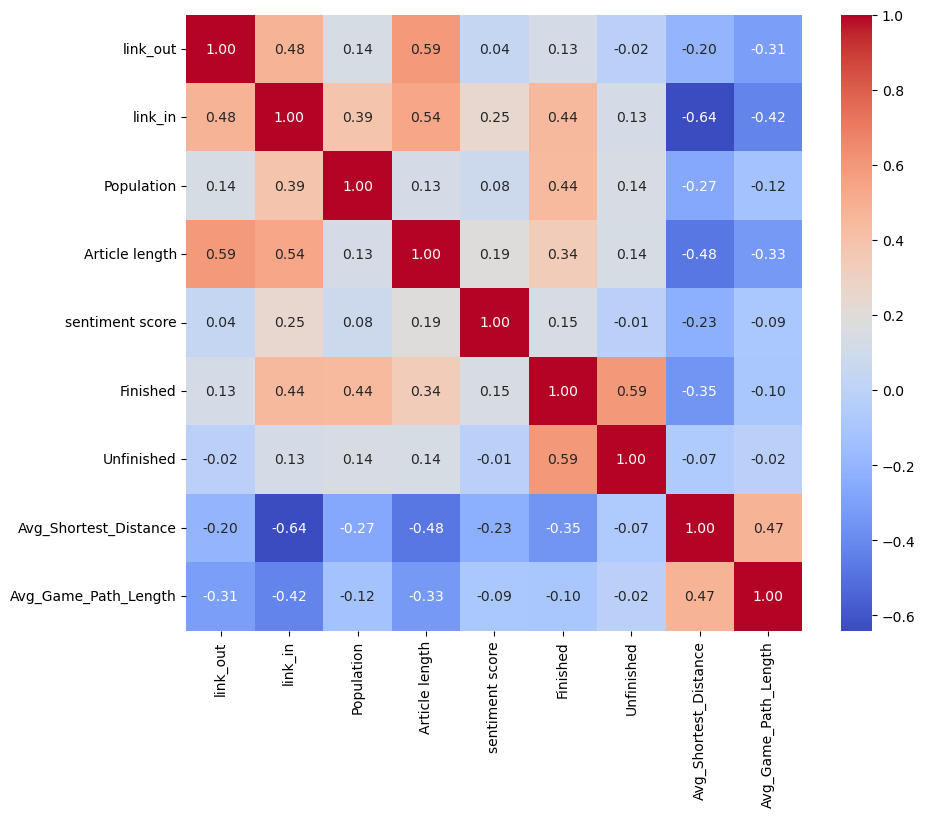

In [45]:
#Check for multicollinearity

# Select only numeric columns for the correlation matrix
numeric_cols = main_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)

# Show the plot
plt.show()

Red show high correlation, blue shows low correlation. Article length correlates with link in and link out. Population appears not to correlate with article length, this could be because article length come from historical importance or country's influence (maybe economic classificaiton would be a good metric, but it wa snot shown because it is not a numerical row)

In [46]:
#Adding economic classification

# List all unique economic classifications
unique_economic_classes = main_df['Economic classification'].unique()
print(unique_economic_classes)

economic_class_mapping = {
    'Low-income': 1, 
    'Lower middle income': 2,
    'Upper middle income': 3,
    'High-income': 4
}

# Map the economic classifications to their respective ordinal number
main_df['Economic classification_dummy'] = main_df['Economic classification'].map(economic_class_mapping)

# Display the updated DataFrame
display(main_df)

['High-income' 'Lower middle income' 'Upper middle income' 'Low-income']


,Country,link_out,link_in,Region,Population,Economic classification,Article length,sentiment score,Finished,Unfinished,Avg_Shortest_Distance,Avg_Game_Path_Length,Economic classification_dummy
0,United States,294.0,1551.0,Northern America,3.188571e+08,High-income,64482.0,0.030681,28.0,3.0,1.612903,2.096774,4
2,Armenia,186.0,99.0,Western Asia,3.013839e+06,Lower middle income,45797.0,0.021531,9.0,1.0,2.600000,3.600000,2
4,Turkey,172.0,249.0,Western Asia,7.769590e+07,Upper middle income,46426.0,0.003038,21.0,2.0,2.086957,3.086957,3
5,Israel,169.0,236.0,Western Asia,8.215668e+06,High-income,66246.0,-0.046935,27.0,3.0,2.433333,3.700000,4
6,Germany,169.0,743.0,Western Europe,8.098250e+07,High-income,68951.0,-0.036626,49.0,6.0,1.600000,2.527273,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,Liberia,21.0,61.0,Sub-Saharan Africa,3.946311e+06,Low-income,22281.0,-0.121275,15.0,1.0,2.625000,4.687500,1
203,Guinea-Bissau,21.0,52.0,Sub-Saharan Africa,1.514451e+06,Low-income,9618.0,-0.092631,7.0,0.0,2.428571,7.142857,1
205,Paraguay,20.0,39.0,Latin America,6.657232e+06,Lower middle income,9346.0,-0.028492,27.0,1.0,2.607143,4.642857,2
211,United Arab Emirates,18.0,59.0,Western Asia,8.798841e+06,High-income,12581.0,-0.044119,56.0,8.0,2.812500,4.328125,4


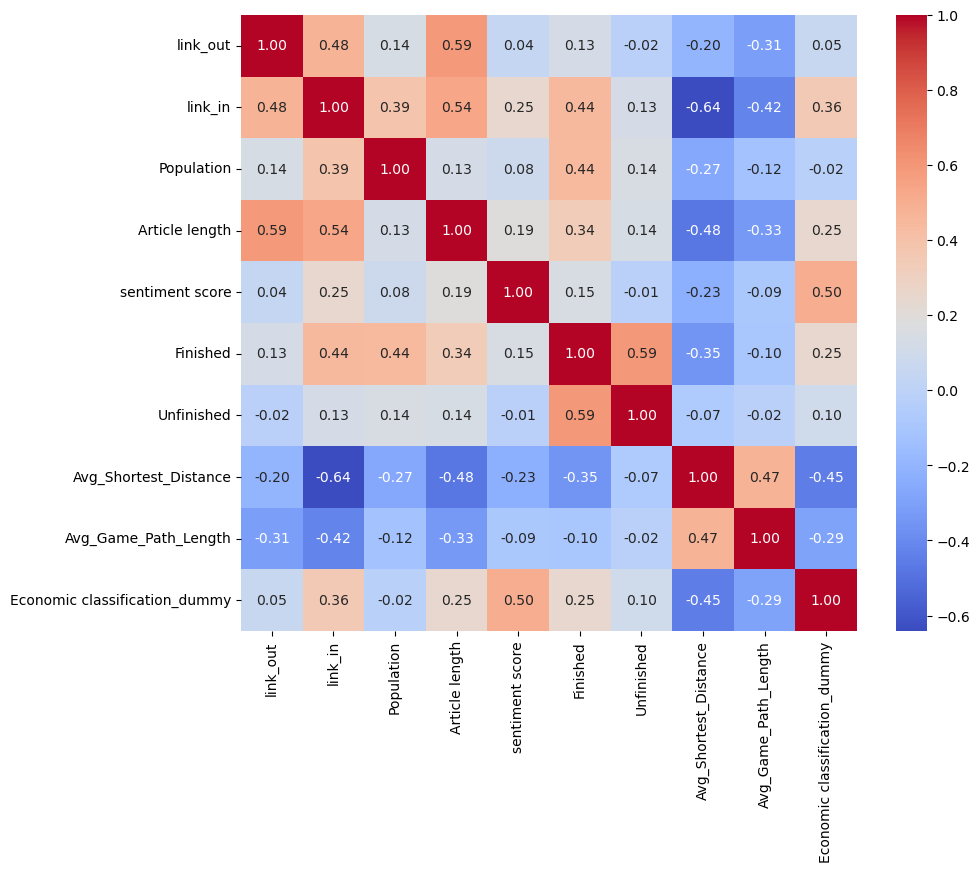

In [47]:
#correlation matrix with economic classification

# Select only numeric columns for the correlation matrix
numeric_cols = main_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)

# Show the plot
plt.show()

High correlation between shortest avg distance and avg game path, suggesting shorter paths are more likely to be completed
High inverse correlation between avg_short_distance and link_in suggesting that countries with more links in are more likely to be completed
High correlation between link_in and article length suggesting that longer articles are more likely to be completed
High correlation between Economic classification and link_in suggesting that countries with more links in are more likely to be completed, BUT higher economic classification
is not related with article length

1. Higher economic classification -> more links_in
2. Longer articles -> more links_in

High correlation between economic classification and sentiment score suggesting that countries with higher sentiment scores are more likely to be completed


In [48]:
#Adding, regions ro correlation matrix

# Array of the 17 regions
regions = ['Northern America', 'Western Asia', 'Western Europe', 'Northern Europe', 'Latin America', 
           'Sub-Saharan Africa', 'Eastern Europe', 'Southern Europe', 'Northern Africa', 'Southern Asia', 
           'Eastern Asia', 'Australia and New Zealand', 'South-eastern Asia', 'Melanesia', 'Central Asia',
           'Polynesia', 'Micronesia']

# Convert array to DataFrame
regions_df = pd.DataFrame(regions, columns=['Region'])

# Mapping regions to numbers based on geographical proximity
region_mapping = {
    'Northern America': 1,
    'Latin America': 2,
    'Northern Europe': 3,
    'Western Europe': 4,
    'Southern Europe': 5,
    'Eastern Europe': 6,
    'Northern Africa': 7,
    'Sub-Saharan Africa': 8,
    'Western Asia': 9,
    'Central Asia': 10,
    'Eastern Asia': 11,
    'Southern Asia': 12,
    'South-eastern Asia': 13,
    'Australia and New Zealand': 14,
    'Melanesia': 15,
    'Micronesia': 16,
    'Polynesia': 17
}

# Map the regions to their respective ordinal number and add as a new column
main_df['region_dummy'] = main_df['Region'].map(region_mapping)

# Display the updated DataFrame
display(main_df)



,Country,link_out,link_in,Region,Population,Economic classification,Article length,sentiment score,Finished,Unfinished,Avg_Shortest_Distance,Avg_Game_Path_Length,Economic classification_dummy,region_dummy
0,United States,294.0,1551.0,Northern America,3.188571e+08,High-income,64482.0,0.030681,28.0,3.0,1.612903,2.096774,4,1
2,Armenia,186.0,99.0,Western Asia,3.013839e+06,Lower middle income,45797.0,0.021531,9.0,1.0,2.600000,3.600000,2,9
4,Turkey,172.0,249.0,Western Asia,7.769590e+07,Upper middle income,46426.0,0.003038,21.0,2.0,2.086957,3.086957,3,9
5,Israel,169.0,236.0,Western Asia,8.215668e+06,High-income,66246.0,-0.046935,27.0,3.0,2.433333,3.700000,4,9
6,Germany,169.0,743.0,Western Europe,8.098250e+07,High-income,68951.0,-0.036626,49.0,6.0,1.600000,2.527273,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,Liberia,21.0,61.0,Sub-Saharan Africa,3.946311e+06,Low-income,22281.0,-0.121275,15.0,1.0,2.625000,4.687500,1,8
203,Guinea-Bissau,21.0,52.0,Sub-Saharan Africa,1.514451e+06,Low-income,9618.0,-0.092631,7.0,0.0,2.428571,7.142857,1,8
205,Paraguay,20.0,39.0,Latin America,6.657232e+06,Lower middle income,9346.0,-0.028492,27.0,1.0,2.607143,4.642857,2,2
211,United Arab Emirates,18.0,59.0,Western Asia,8.798841e+06,High-income,12581.0,-0.044119,56.0,8.0,2.812500,4.328125,4,9


In [49]:
nan_counts = df.isnull().sum()
for column, count in nan_counts.items():
    print(f"{column}: {count} NaNs")

nan_count = df.isnull().sum().sum()
if nan_count > 0:
    print(f"The DataFrame contains {nan_count} NaN values.")
else:
    print("The DataFrame does not contain any NaN values.")

V1: 0 NaNs
V2: 0 NaNs
V3: 0 NaNs
V4: 0 NaNs
V5: 0 NaNs
V6: 0 NaNs
V7: 0 NaNs
V8: 0 NaNs
V9: 0 NaNs
V10: 0 NaNs
V11: 0 NaNs
V12: 0 NaNs
V13: 0 NaNs
V14: 0 NaNs
V15: 0 NaNs
V16: 0 NaNs
V17: 0 NaNs
V18: 0 NaNs
V19: 0 NaNs
V20: 0 NaNs
V21: 0 NaNs
V22: 0 NaNs
V23: 0 NaNs
V24: 0 NaNs
V25: 0 NaNs
V26: 0 NaNs
V27: 0 NaNs
V28: 0 NaNs
V29: 0 NaNs
V30: 0 NaNs
V31: 0 NaNs
V32: 0 NaNs
V33: 0 NaNs
V34: 0 NaNs
V35: 0 NaNs
V36: 0 NaNs
V37: 0 NaNs
V38: 0 NaNs
V39: 0 NaNs
V40: 0 NaNs
V41: 0 NaNs
V42: 0 NaNs
V43: 0 NaNs
V44: 0 NaNs
V45: 0 NaNs
V46: 0 NaNs
V47: 0 NaNs
V48: 0 NaNs
V49: 0 NaNs
V50: 0 NaNs
V51: 0 NaNs
V52: 0 NaNs
V53: 0 NaNs
V54: 0 NaNs
V55: 0 NaNs
V56: 0 NaNs
V57: 0 NaNs
V58: 0 NaNs
V59: 0 NaNs
V60: 0 NaNs
V61: 0 NaNs
The DataFrame does not contain any NaN values.


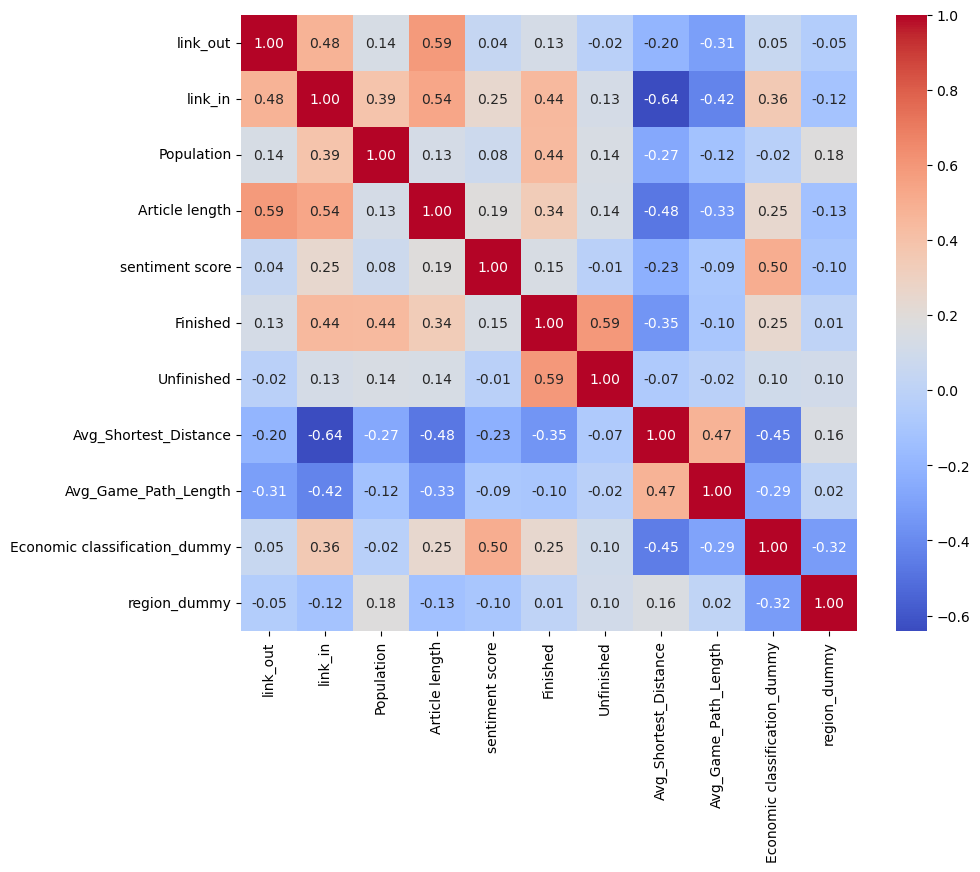

In [50]:
#correlation matrix with region

# Select only numeric columns for the correlation matrix
numeric_cols = main_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)

# Show the plot
plt.show()

### 3.1 Game Bias
To check for inherent bias in the game structure, we will use:

Independent variables: Population, Economic classification, Country, Region

Dependent variables: article length, sentimen score, link_in, avg shortest distance (Link_out is not an advantae in the game, so we will exclude this variable and focus on links_in)

Important: correlation does not necessarily imply causation

In [51]:
display(main_df)

,Country,link_out,link_in,Region,Population,Economic classification,Article length,sentiment score,Finished,Unfinished,Avg_Shortest_Distance,Avg_Game_Path_Length,Economic classification_dummy,region_dummy
0,United States,294.0,1551.0,Northern America,3.188571e+08,High-income,64482.0,0.030681,28.0,3.0,1.612903,2.096774,4,1
2,Armenia,186.0,99.0,Western Asia,3.013839e+06,Lower middle income,45797.0,0.021531,9.0,1.0,2.600000,3.600000,2,9
4,Turkey,172.0,249.0,Western Asia,7.769590e+07,Upper middle income,46426.0,0.003038,21.0,2.0,2.086957,3.086957,3,9
5,Israel,169.0,236.0,Western Asia,8.215668e+06,High-income,66246.0,-0.046935,27.0,3.0,2.433333,3.700000,4,9
6,Germany,169.0,743.0,Western Europe,8.098250e+07,High-income,68951.0,-0.036626,49.0,6.0,1.600000,2.527273,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,Liberia,21.0,61.0,Sub-Saharan Africa,3.946311e+06,Low-income,22281.0,-0.121275,15.0,1.0,2.625000,4.687500,1,8
203,Guinea-Bissau,21.0,52.0,Sub-Saharan Africa,1.514451e+06,Low-income,9618.0,-0.092631,7.0,0.0,2.428571,7.142857,1,8
205,Paraguay,20.0,39.0,Latin America,6.657232e+06,Lower middle income,9346.0,-0.028492,27.0,1.0,2.607143,4.642857,2,2
211,United Arab Emirates,18.0,59.0,Western Asia,8.798841e+06,High-income,12581.0,-0.044119,56.0,8.0,2.812500,4.328125,4,9


In [52]:
# Define the predictor variables (X) and the response variable (y)
X = main_df[['Population', 'Economic classification_dummy', 'region_dummy']]
y = main_df['Article length']

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Build the model
model = sm.OLS(y, X).fit()

# Get the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Article length   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     4.457
Date:                Mon, 18 Dec 2023   Prob (F-statistic):            0.00502
Time:                        18:12:22   Log-Likelihood:                -1618.0
No. Observations:                 148   AIC:                             3244.
Df Residuals:                     144   BIC:                             3256.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

Article length does not seem to be highly predicted by either region, economic classification or population. Suggesting there is no bias in the length of articles, relating to these variables.

In [53]:
# Define the predictor variables (X) and the response variable (y)
X = main_df[['Population', 'Economic classification_dummy', 'region_dummy']]
y = main_df['link_in']

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Build the model
model = sm.OLS(y, X).fit()

# Get the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                link_in   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     19.62
Date:                Mon, 18 Dec 2023   Prob (F-statistic):           1.01e-10
Time:                        18:12:22   Log-Likelihood:                -968.01
No. Observations:                 148   AIC:                             1944.
Df Residuals:                     144   BIC:                             1956.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [54]:
# Define the predictor variables (X) and the response variable (y)
X = main_df[['Economic classification_dummy']]
y = main_df['link_in']

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Build the model
model = sm.OLS(y, X).fit()

# Get the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                link_in   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     21.44
Date:                Mon, 18 Dec 2023   Prob (F-statistic):           8.01e-06
Time:                        18:12:22   Log-Likelihood:                -983.23
No. Observations:                 148   AIC:                             1970.
Df Residuals:                     146   BIC:                             1976.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [55]:
# Define the predictor variables (X) and the response variable (y)
X = main_df[['Economic classification_dummy']]
y = main_df['link_in']

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Fit a Negative Binomial model
model = sm.NegativeBinomial(y, X).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 5.873199
         Iterations: 11
         Function evaluations: 14
         Gradient evaluations: 14
                     NegativeBinomial Regression Results                      
Dep. Variable:                link_in   No. Observations:                  148
Model:               NegativeBinomial   Df Residuals:                      146
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Dec 2023   Pseudo R-squ.:                 0.02886
Time:                        18:12:22   Log-Likelihood:                -869.23
converged:                       True   LL-Null:                       -895.07
Covariance Type:            nonrobust   LLR p-value:                 6.571e-13
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------


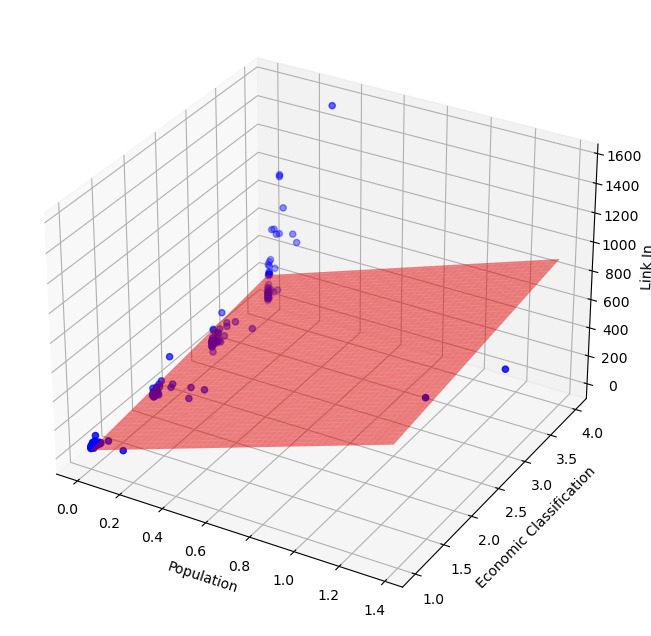

In [56]:
from mpl_toolkits.mplot3d import Axes3D

# Define the predictor variables (X) and the response variable (y)
X = main_df[['Population', 'Economic classification_dummy']]
y = main_df['link_in']
countries = main_df['Country']

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Build the model
model = sm.OLS(y, X).fit()

# Prepare data for the 3D plot
xx, yy = np.meshgrid(np.linspace(X['Population'].min(), X['Population'].max(), 100), 
                     np.linspace(X['Economic classification_dummy'].min(), X['Economic classification_dummy'].max(), 100))
zz = model.params[0] + model.params[1] * xx + model.params[2] * yy

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the original data points
ax.scatter(X['Population'], X['Economic classification_dummy'], y, color='b', marker='o')

# Plot the regression plane
ax.plot_surface(xx, yy, zz, color='r', alpha=0.5)

# Set labels
ax.set_xlabel('Population')
ax.set_ylabel('Economic Classification')
ax.set_zlabel('Link In')

plt.show()

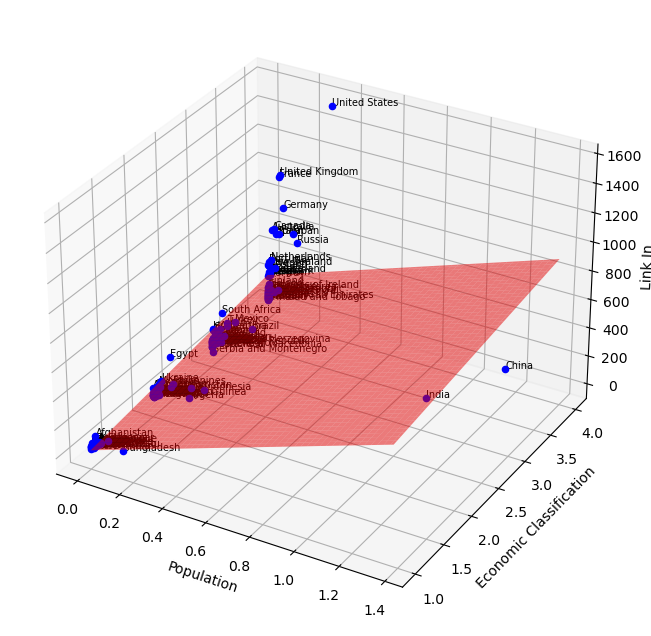

In [57]:
# Re-define the predictor variables (X) and the response variable (y) without adding a constant
X = main_df[['Population', 'Economic classification_dummy']]
y = main_df['link_in']
countries = main_df['Country']

# Build the model with a constant
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()

# Prepare data for 3D plot
xx, yy = np.meshgrid(np.linspace(X['Population'].min(), X['Population'].max(), 100), 
                     np.linspace(X['Economic classification_dummy'].min(), X['Economic classification_dummy'].max(), 100))
zz = model.params[0] + model.params[1] * xx + model.params[2] * yy

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the original data points and label them
for idx, row in main_df.iterrows():
    ax.scatter(row['Population'], row['Economic classification_dummy'], row['link_in'], color='b', marker='o')
    ax.text(row['Population'], row['Economic classification_dummy'], row['link_in'], '%s' % (row['Country']), size=7, zorder=1)

# Plot the regression plane
ax.plot_surface(xx, yy, zz, color='r', alpha=0.5)

# Set labels
ax.set_xlabel('Population')
ax.set_ylabel('Economic Classification')
ax.set_zlabel('Link In')

plt.show()


In [58]:
# Exclude outliers
main_df_no_outliers = main_df[(main_df['Country'] != 'China') & (main_df['Country'] != 'India')]

# Re-run the regression without the outliers
X_no_outliers = main_df_no_outliers[['Population', 'Economic classification_dummy', 'region_dummy']]
y_no_outliers = main_df_no_outliers['link_in']

X_no_outliers = sm.add_constant(X_no_outliers)
model_no_outliers = sm.OLS(y_no_outliers, X_no_outliers).fit()

print(model_no_outliers.summary())


                            OLS Regression Results                            
Dep. Variable:                link_in   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     44.33
Date:                Mon, 18 Dec 2023   Prob (F-statistic):           2.79e-20
Time:                        18:12:31   Log-Likelihood:                -928.60
No. Observations:                 146   AIC:                             1865.
Df Residuals:                     142   BIC:                             1877.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

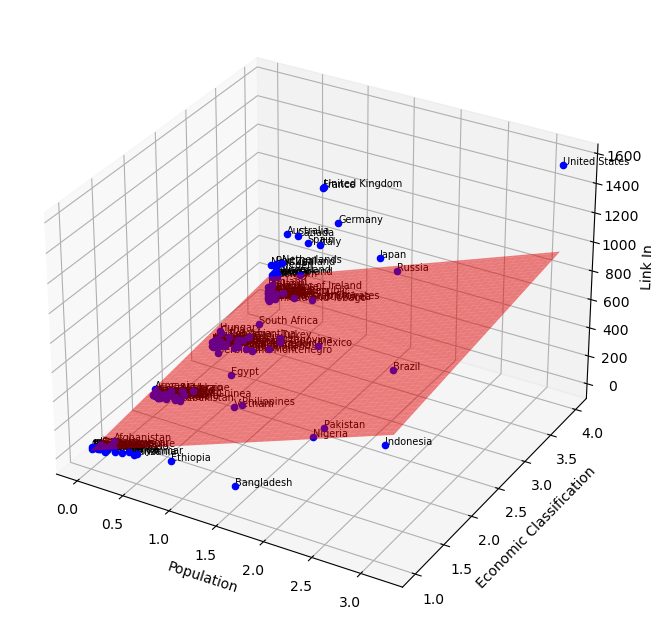

In [59]:
# Prepare data for the 3D plot without the outliers
xx_no_outliers, yy_no_outliers = np.meshgrid(
    np.linspace(X_no_outliers['Population'].min(), X_no_outliers['Population'].max(), 100), 
    np.linspace(X_no_outliers['Economic classification_dummy'].min(), X_no_outliers['Economic classification_dummy'].max(), 100)
)
zz_no_outliers = model_no_outliers.params[0] + model_no_outliers.params[1] * xx_no_outliers + model_no_outliers.params[2] * yy_no_outliers

# Create 3D plot without the outliers
fig_no_outliers = plt.figure(figsize=(10, 8))
ax_no_outliers = fig_no_outliers.add_subplot(111, projection='3d')

# Plot the original data points without the outliers
for idx, row in main_df_no_outliers.iterrows():
    ax_no_outliers.scatter(row['Population'], row['Economic classification_dummy'], row['link_in'], color='b', marker='o')
    ax_no_outliers.text(row['Population'], row['Economic classification_dummy'], row['link_in'], '%s' % (row['Country']), size=7, zorder=1)

# Plot the regression plane without the outliers
ax_no_outliers.plot_surface(xx_no_outliers, yy_no_outliers, zz_no_outliers, color='r', alpha=0.5)

# Set labels
ax_no_outliers.set_xlabel('Population')
ax_no_outliers.set_ylabel('Economic Classification')
ax_no_outliers.set_zlabel('Link In')

plt.show()


In [60]:
# Define the predictor variables (X) and the response variable (y)
X = main_df[['Population', 'Economic classification_dummy', 'region_dummy']]
y = main_df['sentiment score']

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Build the model
model = sm.OLS(y, X).fit()

# Get the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        sentiment score   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     17.29
Date:                Mon, 18 Dec 2023   Prob (F-statistic):           1.21e-09
Time:                        18:12:38   Log-Likelihood:                 215.20
No. Observations:                 148   AIC:                            -422.4
Df Residuals:                     144   BIC:                            -410.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

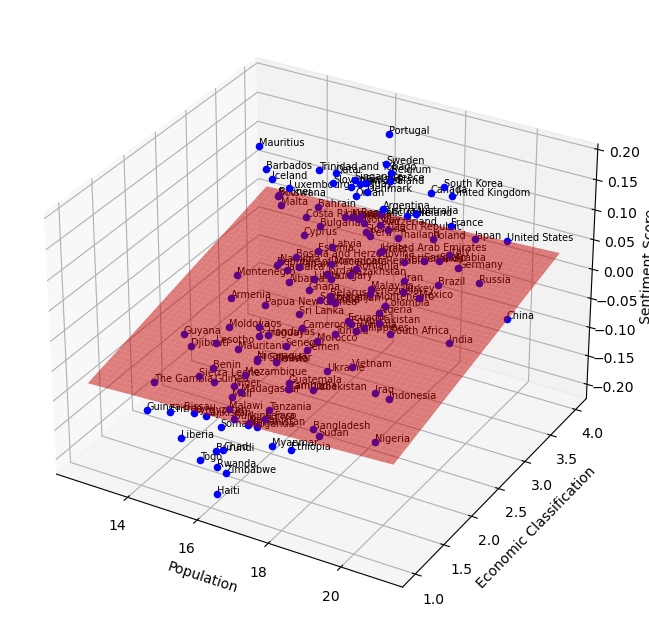

In [73]:
# Re-define the predictor variables (X) and the response variable (y) without adding a constant
X = main_df[['Population', 'Economic classification_dummy']].copy()
X['Population'] = np.log(X['Population'])
y = main_df['sentiment score']
countries = main_df['Country']

# Build the model with a constant
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()

# Prepare data for 3D plot
xx, yy = np.meshgrid(np.linspace(X['Population'].min(), X['Population'].max(), 100), 
                     np.linspace(X['Economic classification_dummy'].min(), X['Economic classification_dummy'].max(), 100))
zz = model.params[0] + model.params[1] * xx + model.params[2] * yy

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the original data points and label them
for idx, row in main_df.iterrows():
    ax.scatter(np.log(row['Population']), row['Economic classification_dummy'], row['sentiment score'], color='b', marker='o')
    ax.text(np.log(row['Population']), row['Economic classification_dummy'], row['sentiment score'], '%s' % (row['Country']), size=7, zorder=1)

# Plot the regression plane
ax.plot_surface(xx, yy, zz, color='r', alpha=0.5)

# Set labels
ax.set_xlabel('Population')
ax.set_ylabel('Economic Classification')
ax.set_zlabel('Sentiment Score')

plt.show()

In [62]:
# Exclude outliers
main_df_no_outliers = main_df[(main_df['Country'] != 'China') & (main_df['Country'] != 'India')]

# Re-run the regression without the outliers
X_no_outliers = main_df_no_outliers[['Population', 'Economic classification_dummy', 'region_dummy']]
y_no_outliers = main_df_no_outliers['sentiment score']

X_no_outliers = sm.add_constant(X_no_outliers)
model_no_outliers = sm.OLS(y_no_outliers, X_no_outliers).fit()

print(model_no_outliers.summary())


                            OLS Regression Results                            
Dep. Variable:        sentiment score   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     16.95
Date:                Mon, 18 Dec 2023   Prob (F-statistic):           1.83e-09
Time:                        18:12:45   Log-Likelihood:                 211.80
No. Observations:                 146   AIC:                            -415.6
Df Residuals:                     142   BIC:                            -403.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

Not a significant improvement removing population outliers



In [63]:
# Re-run the regression only with economic classification
X_no_outliers = main_df_no_outliers[['Economic classification_dummy']]
y_no_outliers = main_df_no_outliers['sentiment score']

X_no_outliers = sm.add_constant(X_no_outliers)
model_no_outliers = sm.OLS(y_no_outliers, X_no_outliers).fit()

print(model_no_outliers.summary())

                            OLS Regression Results                            
Dep. Variable:        sentiment score   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     50.66
Date:                Mon, 18 Dec 2023   Prob (F-statistic):           4.79e-11
Time:                        18:12:45   Log-Likelihood:                 211.46
No. Observations:                 146   AIC:                            -418.9
Df Residuals:                     144   BIC:                            -413.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

    Positive Relationship: The coefficient for Economic classification_dummy is positive (0.0298) and statistically significant (p < 0.001). This indicates that there is a positive association between economic classification and sentiment score. Higher economic classification is associated with a more positive sentiment score.

    Model Fit: The R-squared value is 0.260, suggesting that approximately 26% of the variance in sentiment scores can be explained by economic classification alone. This is a substantial amount for a single variable model.

    Bias Interpretation: The term "bias" in this context is being used to describe a systematic favoritism or skew in sentiment scores towards countries with higher economic classifications. The regression results support the notion that there is a statistically significant association where higher economic classifications correspond to more positive sentiment scores.

    Causality Caution: While the model shows an association, it does not prove causality. We cannot say definitively that the higher economic classification causes more positive sentiment without further investigation. Other variables and underlying factors might influence this relationship.

    Broader Context: The analysis would benefit from considering additional context, such as the source of the sentiment scores, the methodology used to calculate them, and potential confounding variables that are not included in the model.

In summary, the results suggest that sentiment scores are associated with economic classification, with higher classifications linked to more positive scores. While this could be interpreted as a "bias" towards countries with higher economic classifications, the findings should be understood as indicative of a correlation, not necessarily causation. More comprehensive analysis would be needed to understand the full picture and to explore the reasons behind this association.

## EVERYTHING BELOW HAS ONE HOT ENCODING FOR REGIONS

In [80]:
#Adding one hot encoding region columns

# List of region names
regions = [
    'Northern America', 'Latin America', 'Northern Europe', 'Western Europe',
    'Southern Europe', 'Eastern Europe', 'Northern Africa', 'Sub-Saharan Africa',
    'Western Asia', 'Central Asia', 'Eastern Asia', 'Southern Asia',
    'South-eastern Asia', 'Australia and New Zealand', 'Melanesia', 
    'Micronesia', 'Polynesia'
]
print(len(regions))

# Add 17 new columns to main_df, one for each region
for region in regions:
    # Initialize new columns with 0
    main_df[region] = 0

# Map the 'Region' column to the new binary columns
for idx, row in main_df.iterrows():
    if row['Region'] in regions:
        # Set the corresponding region column to 1
        main_df.at[idx, row['Region']] = 1

# main_df now contains the updated DataFrame with the new binary columns
main_df.head(20)


17


,Country,link_out,link_in,Region,Population,Economic classification,Article length,sentiment score,Finished,Unfinished,...,Sub-Saharan Africa,Western Asia,Central Asia,Eastern Asia,Southern Asia,South-eastern Asia,Australia and New Zealand,Melanesia,Micronesia,Polynesia
0,United States,294.0,1551.0,Northern America,3.188571e+08,High-income,64482.0,0.030681,28.0,3.0,...,0,0,0,0,0,0,0,0,0,0
2,Armenia,186.0,99.0,Western Asia,3.013839e+06,Lower middle income,45797.0,0.021531,9.0,1.0,...,0,1,0,0,0,0,0,0,0,0
4,Turkey,172.0,249.0,Western Asia,7.769590e+07,Upper middle income,46426.0,0.003038,21.0,2.0,...,0,1,0,0,0,0,0,0,0,0
5,Israel,169.0,236.0,Western Asia,8.215668e+06,High-income,66246.0,-0.046935,27.0,3.0,...,0,1,0,0,0,0,0,0,0,0
6,Germany,169.0,743.0,Western Europe,8.098250e+07,High-income,68951.0,-0.036626,49.0,6.0,...,0,0,0,0,0,0,0,0,0,0
7,United Kingdom,168.0,972.0,Northern Europe,6.459675e+07,High-income,61786.0,0.082581,28.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8,Argentina,163.0,189.0,Latin America,4.266950e+07,Upper middle income,77769.0,0.131566,27.0,6.0,...,0,0,0,0,0,0,0,0,0,0
9,Mozambique,162.0,98.0,Sub-Saharan Africa,2.504192e+07,Low-income,36260.0,0.017097,9.0,1.0,...,1,0,0,0,0,0,0,0,0,0
10,Uganda,160.0,81.0,Sub-Saharan Africa,3.463465e+07,Low-income,25252.0,-0.062350,21.0,2.0,...,1,0,0,0,0,0,0,0,0,0
11,Saudi Arabia,160.0,110.0,Western Asia,3.033980e+07,High-income,36921.0,-0.042418,18.0,1.0,...,0,1,0,0,0,0,0,0,0,0


In [81]:
# Define the predictor variables (X) and the response variable (y)
# Use the 17 region columns as predictors
X = main_df[regions]
y = main_df['link_in']

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Build the model
model = sm.OLS(y, X).fit()

# Get the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                link_in   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     9.236
Date:                Mon, 18 Dec 2023   Prob (F-statistic):           6.24e-14
Time:                        18:47:58   Log-Likelihood:                -943.11
No. Observations:                 148   AIC:                             1916.
Df Residuals:                     133   BIC:                             1961.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/home/fmorales/miniconda3/envs/ada/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning:

divide by zero encountered in scalar divide



In [82]:
# Define the predictor variables (X) and the response variable (y)
# Use the 17 region columns as predictors
X = main_df[regions]
y = main_df['sentiment score']

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Build the model
model = sm.OLS(y, X).fit()

# Get the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        sentiment score   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     1.950
Date:                Mon, 18 Dec 2023   Prob (F-statistic):             0.0265
Time:                        18:55:00   Log-Likelihood:                 206.26
No. Observations:                 148   AIC:                            -382.5
Df Residuals:                     133   BIC:                            -337.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/home/fmorales/miniconda3/envs/ada/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning:

divide by zero encountered in scalar divide



In [83]:
# Define the predictor variables (X) and the response variable (y)
# Use the 17 region columns, economic classification, and log of population as predictors
X = main_df[regions + ['Economic classification_dummy']]
X['Log_Population'] = np.log(main_df['Population'].replace(0, np.nan))  # Replace 0 with NaN to avoid log(0)

# Handling missing values if any
X = X.dropna()

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Since we dropped NaN values from X, we need to align y with X
y = main_df.loc[X.index, 'link_in']

# Build the model
model = sm.OLS(y, X).fit()

# Get the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                link_in   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     18.99
Date:                Mon, 18 Dec 2023   Prob (F-statistic):           9.82e-27
Time:                        18:57:33   Log-Likelihood:                -904.59
No. Observations:                 148   AIC:                             1843.
Df Residuals:                     131   BIC:                             1894.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

/tmp/ipykernel_43293/3560017647.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



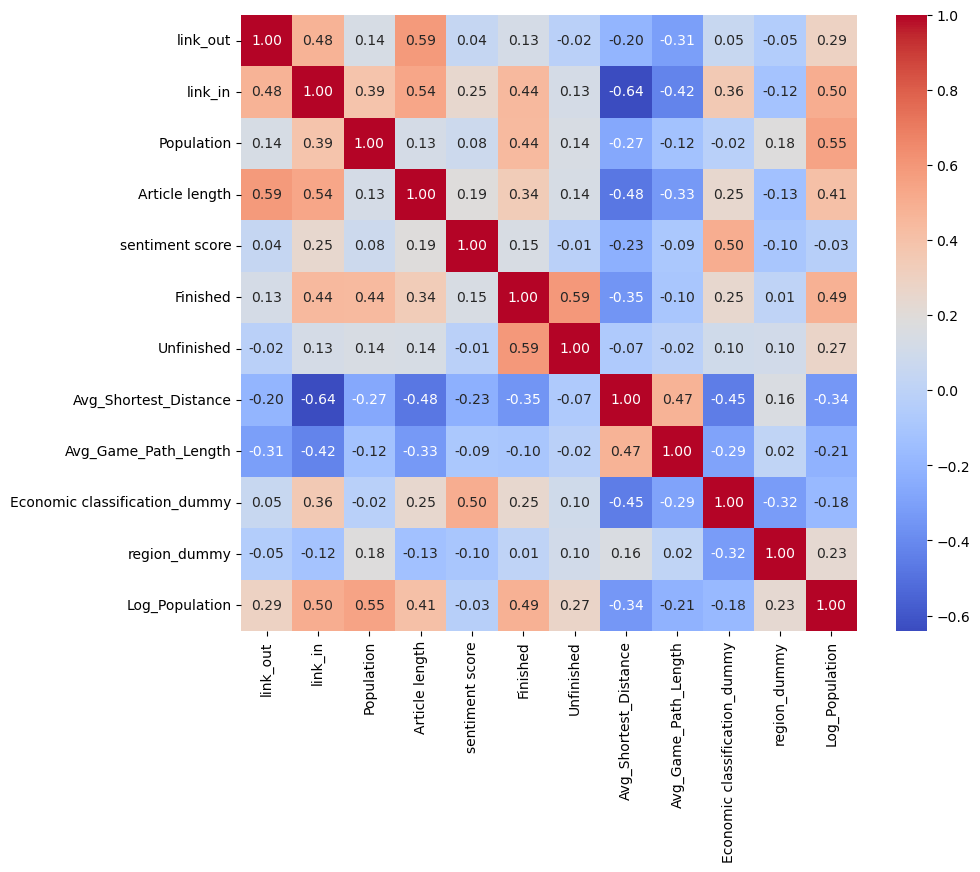

In [85]:
#Correlation using the population log

regions = [
    'Northern America', 'Latin America', 'Northern Europe', 'Western Europe',
    'Southern Europe', 'Eastern Europe', 'Northern Africa', 'Sub-Saharan Africa',
    'Western Asia', 'Central Asia', 'Eastern Asia', 'Southern Asia',
    'South-eastern Asia', 'Australia and New Zealand', 'Melanesia', 
    'Micronesia', 'Polynesia'
]

# Drop the columns
main_df = main_df.drop(columns=regions)

main_df['Log_Population'] = np.log(main_df['Population'].replace(0, np.nan))
main_df = main_df.dropna(subset=['Log_Population'])

# Select only numeric columns for the correlation matrix, including the new Log_Population column
numeric_cols = main_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)

# Show the plot
plt.show()
